In [1]:
#Fourth stage. Analyze and visualize trends in RF. Manuscript figures produced.

import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import pyresample
import dask.array as da
import pandas as pd
from tqdm.notebook import trange, tqdm
import gc
import calendar
from scipy.stats.mstats import theilslopes
from sklearn.metrics import r2_score
from sklearn.linear_model import TheilSenRegressor
import statsmodels.api as sm
import matplotlib.ticker as mticker
from mpl_toolkits.axes_grid1 import make_axes_locatable
from cartopy.mpl.ticker import (LongitudeFormatter, LatitudeFormatter,
                                LatitudeLocator)
plt.rcParams.update({'font.size': 16})

datadriveletter = 'Z:'
prod_data_dir = datadriveletter + '/radiative_forcing_2020/production_data/'

figure_dir = datadriveletter + '/radiative_forcing_2020/manuscript_figures/'
startyear = 1982
stopyear = 2018

NH_months = [3,4,5,6,7,8] #not really used, reminder of which months produce the actual data
SH_months = [1,2,3,10,11,12] #same as above

NH_latlimit = 50
SH_latlimit = -50

fillval_RF = 0.05
#fillval_RF = 0.0

hem_area_sqm = 255000000*(1000*1000)
area_normalization = (25000*25000) / (hem_area_sqm*2.0) #to calculate delta-CrRF on the scale of the globe

# prep for surface state change calculations
statechange = {'SNOW_TO_NOSNOW':1,\
              'NOSNOW_TO_SNOW':2,\
              'SEAICE_TO_WATER':3,\
              'WATER_TO_SEAICE':4,\
              'SNOW':5,\
              'LAND':6,\
              'SEAICE':7,\
              'WATER':8}

In [2]:
WSA_EASE2_all_NH = xr.open_dataarray(prod_data_dir + '/C2_SAL_WSA_all_NH_1982_2018.nc')
WSA_EASE2_all_SH = xr.open_dataarray(prod_data_dir + '/C2_SAL_WSA_all_SH_1982_2018_v3.nc')

In [3]:
CACK_ALB_KERNEL_EASE2_NH_xr = xr.open_dataarray(datadriveletter+'/EASE2_reprojected/TOA_RF_kernel_for_ALBEDO_CACK_extended_climatology_bf_fill_NH.nc')
CACK_ALB_KERNEL_EASE2_SH_xr = xr.open_dataarray(datadriveletter+'/EASE2_reprojected/TOA_RF_kernel_for_ALBEDO_CACK_extended_climatology_bf_fill_SH.nc')

CC_ALB_KERNEL_EASE2_NH_xr = xr.open_dataarray(datadriveletter+'/EASE2_reprojected/TOA_RF_kernel_for_ALBEDO_CC_NH.nc')
CC_ALB_KERNEL_EASE2_SH_xr = xr.open_dataarray(datadriveletter+'/EASE2_reprojected/TOA_RF_kernel_for_ALBEDO_CC_SH.nc')


In [4]:
radiative_forcing_CLARAWSA_CACK_NH = xr.open_dataarray(prod_data_dir + 'Radiative_forcing_C2WSA_CACK_NH_full_OSA_climat_bf_fill_v2.nc')
#A few perturbed pixels end up out of scale
radiative_forcing_CLARAWSA_CACK_NH = xr.where(radiative_forcing_CLARAWSA_CACK_NH==np.inf, np.nan, radiative_forcing_CLARAWSA_CACK_NH)
radiative_forcing_CLARAWSA_CACK_NH = xr.where(radiative_forcing_CLARAWSA_CACK_NH==-np.inf, np.nan, radiative_forcing_CLARAWSA_CACK_NH)


radiative_forcing_CLARAWSA_CC_NH = xr.open_dataarray(prod_data_dir + 'Radiative_forcing_C2WSA_CC_NH_full_OSA_v2.nc')

In [5]:
radiative_forcing_CLARAWSA_CACK_SH = xr.open_dataarray(prod_data_dir + 'Radiative_forcing_C2WSA_CACK_OSA_SH_full_climat_bf_fill_v2.nc')
#fix out of scale
radiative_forcing_CLARAWSA_CACK_SH = xr.where(radiative_forcing_CLARAWSA_CACK_SH==np.inf, np.nan, radiative_forcing_CLARAWSA_CACK_SH)
radiative_forcing_CLARAWSA_CACK_SH = xr.where(radiative_forcing_CLARAWSA_CACK_SH==-np.inf, np.nan, radiative_forcing_CLARAWSA_CACK_SH)

radiative_forcing_CLARAWSA_CC_SH = xr.open_dataarray(prod_data_dir + 'Radiative_forcing_C2WSA_CC_OSA_SH_full_v2.nc')

In [6]:

annual_mean_CC_NH = radiative_forcing_CLARAWSA_CC_NH.fillna(fillval_RF).where(radiative_forcing_CLARAWSA_CC_NH.latitude>NH_latlimit).sum(('lat', 'lon')).resample(time='AS').mean('time') * area_normalization #Global mean effect
annual_mean_CACK_NH = radiative_forcing_CLARAWSA_CACK_NH.fillna(fillval_RF).where(radiative_forcing_CLARAWSA_CC_NH.latitude>NH_latlimit).sum(('lat', 'lon')).resample(time='AS').mean('time') * area_normalization #Global mean effect
annual_mean_CC_SH = radiative_forcing_CLARAWSA_CC_SH.fillna(fillval_RF).where(radiative_forcing_CLARAWSA_CC_SH.latitude<SH_latlimit).sum(('lat', 'lon')).resample(time='AS').mean('time') * area_normalization #Global mean effect
annual_mean_CACK_SH = radiative_forcing_CLARAWSA_CACK_SH.fillna(fillval_RF).where(radiative_forcing_CLARAWSA_CC_SH.latitude<SH_latlimit).sum(('lat', 'lon')).resample(time='AS').mean('time') * area_normalization #Global mean effect
#

In [7]:
annual_mean_CACK_NH

<xarray.DataArray (perturbation: 3, time: 37)>
array([[-5.26354940e-02, -7.17772247e-02,  4.11293721e-02,
        -5.20095133e-02, -4.30697380e-02, -5.78130685e-02,
         6.80696159e-02,  1.44829592e-02,  1.29116748e-01,
         4.18356528e-02, -1.12370225e-01,  6.16179141e-02,
         5.46476665e-02,  9.87144930e-02, -4.27420307e-02,
         1.04429442e-01,  9.47217459e-02,  5.32982627e-02,
         7.21063943e-02,  8.73815183e-02,  6.04845154e-02,
         6.58401006e-02,  3.24558389e-02,  1.42549346e-01,
         1.10704562e-01,  1.68610695e-01,  1.46622136e-01,
         8.76510725e-02,  2.06589211e-01,  1.87535934e-01,
         1.74549334e-01,  6.34849990e-02,  1.42185113e-01,
         1.87211986e-01,  2.50773538e-01,  1.86722867e-01,
         1.42724585e-01],
       [ 3.92122395e-02,  1.76393501e-02,  1.32198323e-01,
         3.70787344e-02,  4.94856156e-02,  3.20412871e-02,
         1.59401329e-01,  1.07021220e-01,  2.21309004e-01,
         1.33056809e-01, -2.32658235e-02,  1.52956572e-01,
         1.42088431e-01,  1.89100856e-01,  4.99974447e-02,
         1.98886146e-01,  1.88229811e-01,  1.43683666e-01,
         1.61075464e-01,  1.82022335e-01,  1.52478677e-01,
         1.54608770e-01,  1.21925898e-01,  2.36519593e-01,
         1.98055803e-01,  2.55813603e-01,  2.37317555e-01,
         1.77281294e-01,  2.94593082e-01,  2.77780464e-01,
         2.59140464e-01,  1.52306453e-01,  2.32983031e-01,
         2.74167340e-01,  3.36863376e-01,  2.77017923e-01,
         2.30341552e-01],
       [-1.46338653e-01, -1.67969515e-01, -4.63995119e-02,
        -1.48575679e-01, -1.35407673e-01, -1.53585783e-01,
        -1.74431074e-02, -7.56951611e-02,  4.61284089e-02,
        -4.74414473e-02, -2.12857662e-01, -2.45757293e-02,
        -3.23969554e-02,  1.17512053e-02, -1.36392390e-01,
         2.22593085e-02,  1.11246425e-02, -3.49424431e-02,
        -1.49181438e-02, -2.89806273e-05, -3.00511691e-02,
        -2.18925727e-02, -6.12392307e-02,  5.71609172e-02,
         2.33163618e-02,  8.46296340e-02,  6.17480631e-02,
        -2.76070379e-03,  1.26497586e-01,  1.02888825e-01,
         8.94930728e-02, -2.88442524e-02,  5.80365855e-02,
         1.02583050e-01,  1.72700766e-01,  1.05761383e-01,
         5.60491231e-02]])
Coordinates:
  * time     (time) datetime64[ns] 1982-01-01 1983-01-01 ... 2018-01-01
Dimensions without coordinates: perturbation

In [8]:
annual_mean_CC_NH_under80 = radiative_forcing_CLARAWSA_CC_NH.fillna(fillval_RF).where(radiative_forcing_CLARAWSA_CC_NH.latitude<80).where(radiative_forcing_CLARAWSA_CC_NH.latitude>NH_latlimit).sum(('lat', 'lon')).resample(time='AS').mean('time') * area_normalization #Global mean effect
annual_mean_CC_SH_under80 = radiative_forcing_CLARAWSA_CC_SH.fillna(fillval_RF).where(radiative_forcing_CLARAWSA_CC_SH.latitude>-80).where(radiative_forcing_CLARAWSA_CC_SH.latitude<SH_latlimit).sum(('lat', 'lon')).resample(time='AS').mean('time') * area_normalization #Global mean effect


In [9]:
Arctic_SIC = xr.open_dataarray(datadriveletter+'/EASE2_reprojected/Arctic_seaice.nc')
Antarctic_SIC = xr.open_dataarray(prod_data_dir+'G02202_Antarctic_seaice_full_1978_2018_v2.nc')


(array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

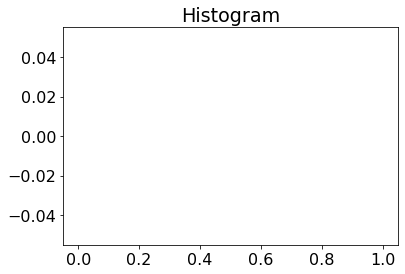

In [10]:
Arctic_SIC.sel(time='1988-01').plot()

In [11]:
alteredstate_NH = xr.open_dataarray(prod_data_dir+'Surfacechange_NH_1982_2018_amendedseaice_v2.nc')
alteredstate_SH = xr.open_dataarray(prod_data_dir+'Surfacechange_SH_1982_2018_amendedseaice_v2.nc')

In [12]:
#calculate potential uncertainty related to missing albedo data over the poles. 
#Assume that missing data can 'hide' albedo changes, variable by month and domain (Antarctic snow changes expected negligible to minor)
#Then use the larger of this uncertainty and the overall albedo+kernel RF retrieval uncertainty in the result fig.
def get_albedoloss(ts, region):
    #print(ts.time.dt.month.values)
    albedoloss_NH = [np.nan, -0.04, -0.04, -0.15, -0.4, -0.4, -0.4, -0.4, -0.4, -0.3, -0.3, -0.2, -0.2]
    albedoloss_SH = [np.nan, -0.4, -0.4, -0.3, -0.2, -0.04, -0.04, -0.04, -0.04, -0.04, -0.1, -0.2, -0.4]
    if region=='NH':
        return [albedoloss_NH[i] for i in ts.time.dt.month.values]
    else:
        return [albedoloss_SH[i] for i in ts.time.dt.month.values]

albedo_lost_signal_NH = np.array([np.tile(x,(720,720)) for x in get_albedoloss(CACK_ALB_KERNEL_EASE2_NH_xr.time, 'NH')])
albedo_lost_signal_SH = np.array([np.tile(x,(720,720)) for x in get_albedoloss(CACK_ALB_KERNEL_EASE2_SH_xr.time, 'SH')])
albedo_lost_signal_SH = xr.where(alteredstate_SH==statechange['SNOW'], -0.05, albedo_lost_signal_SH)

#calculate fractions of analysis area where kernels>0 and no albedo is available, i.e. what signal might we be missing?
missingsignal_CACK_NH = CACK_ALB_KERNEL_EASE2_NH_xr.where((CACK_ALB_KERNEL_EASE2_NH_xr.latitude>NH_latlimit) & (CACK_ALB_KERNEL_EASE2_NH_xr>0)).where(np.isnan(WSA_EASE2_all_NH))
missingsignal_CACK_SH = CACK_ALB_KERNEL_EASE2_SH_xr.where((CACK_ALB_KERNEL_EASE2_SH_xr.latitude<SH_latlimit) & (CACK_ALB_KERNEL_EASE2_SH_xr>0)).where(np.isnan(WSA_EASE2_all_SH))

#replicate CC to full extent
CC_NH_full = [CC_ALB_KERNEL_EASE2_NH_xr.sel(time=x.dt.month) for x in missingsignal_CACK_NH.time]
CC_NH_full = xr.concat(CC_NH_full, 'time')
CC_NH_full['time'] = missingsignal_CACK_NH.time

CC_SH_full = [CC_ALB_KERNEL_EASE2_SH_xr.sel(time=x.dt.month) for x in missingsignal_CACK_SH.time]
CC_SH_full = xr.concat(CC_SH_full, 'time')
CC_SH_full['time'] = missingsignal_CACK_SH.time

missingsignal_CC_NH = CC_NH_full.where((CC_NH_full.latitude>NH_latlimit) & (CC_NH_full>0)).where(np.isnan(WSA_EASE2_all_NH))
missingsignal_CC_SH = CC_SH_full.where((CC_SH_full.latitude<SH_latlimit) & (CC_SH_full!=0)).where(np.isnan(WSA_EASE2_all_SH))


#annual global mean
missing_RF_CACK_NH = (missingsignal_CACK_NH * -1 * albedo_lost_signal_NH).sum(('lat','lon')).resample(time='AS').mean('time') * area_normalization
missing_RF_CACK_SH = (missingsignal_CACK_SH * -1 * albedo_lost_signal_SH).sum(('lat','lon')).resample(time='AS').mean('time') * area_normalization

missing_RF_CC_NH = (missingsignal_CC_NH * albedo_lost_signal_NH/0.01).sum(('lat','lon')).resample(time='AS').mean('time') * area_normalization
missing_RF_CC_SH = (missingsignal_CC_SH * albedo_lost_signal_SH/0.01).sum(('lat','lon')).resample(time='AS').mean('time') * area_normalization



In [13]:
missing_RF_CACK_NH

<xarray.DataArray (time: 37)>
array([0.10703102, 0.11146353, 0.10496203, 0.09725905, 0.10108007,
       0.10145819, 0.11240797, 0.10053196, 0.0949489 , 0.09532499,
       0.09821975, 0.10253222, 0.11270561, 0.09198375, 0.09093608,
       0.09365481, 0.09689374, 0.09875211, 0.11876485, 0.0923575 ,
       0.09079743, 0.08820135, 0.08865051, 0.09438173, 0.09874081,
       0.09258265, 0.09213447, 0.09036702, 0.09183519, 0.09357669,
       0.09709346, 0.09414196, 0.10135671, 0.09529495, 0.10375993,
       0.10551117, 0.10097623])
Coordinates:
  * time     (time) datetime64[ns] 1982-01-01 1983-01-01 ... 2018-01-01

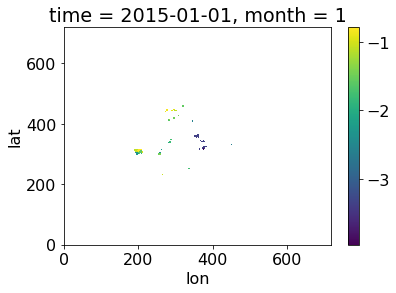

In [14]:
missingsignal_CC_SH[-48,:,:].plot()

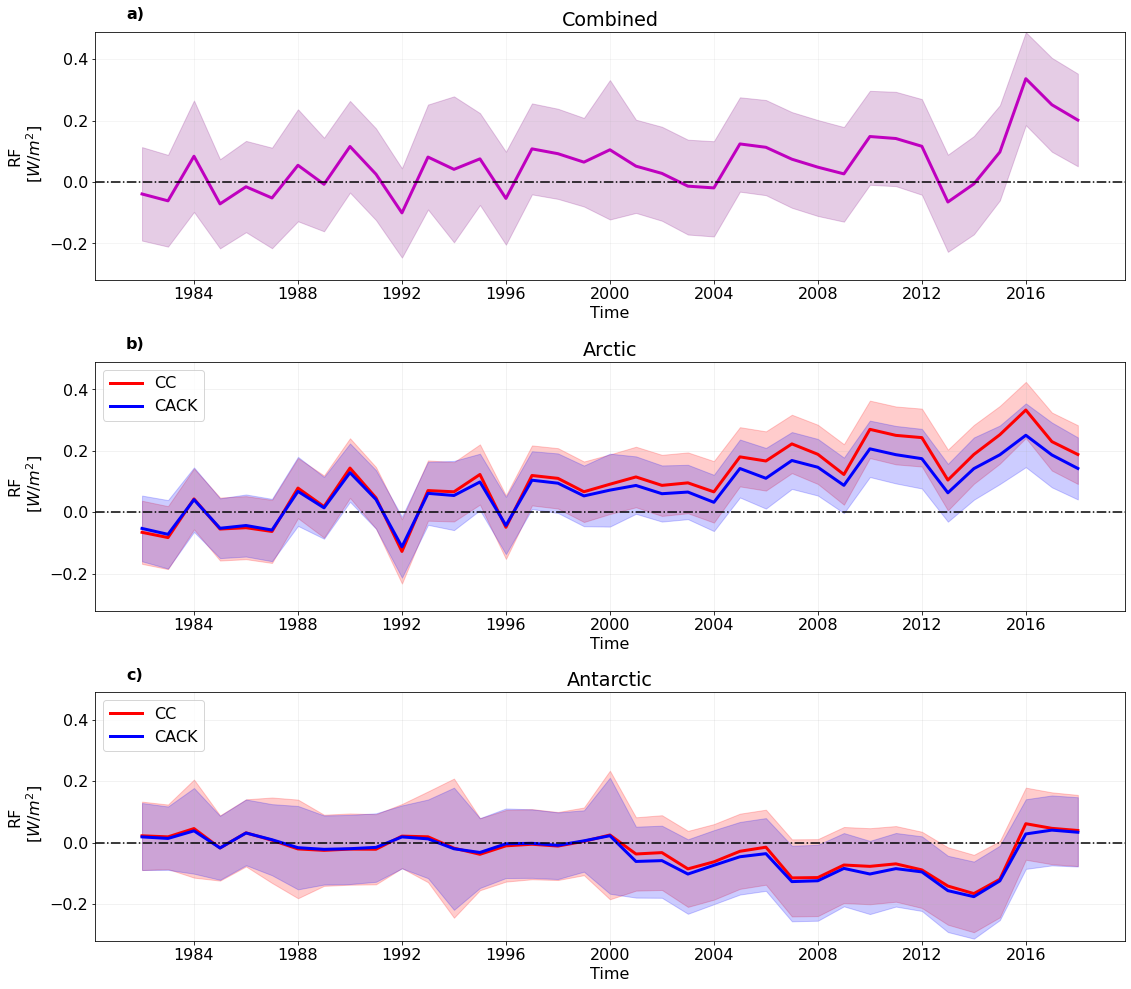

In [15]:
plt.figure(figsize=(16,14))
ymax = 0.49
ymin = -0.32

#NH

upperfill_CC_NH = np.maximum(annual_mean_CC_NH.sel(perturbation=1).values, \
                             annual_mean_CC_NH.sel(perturbation=0).values + missing_RF_CC_NH )

lowerfill_CC_NH = np.minimum(annual_mean_CC_NH.sel(perturbation=2).values, \
                             annual_mean_CC_NH.sel(perturbation=0).values -1*missing_RF_CC_NH )

upperfill_CACK_NH = np.maximum(annual_mean_CACK_NH.sel(perturbation=1).values, \
                               annual_mean_CACK_NH.sel(perturbation=0).values + missing_RF_CACK_NH )

lowerfill_CACK_NH = np.minimum(annual_mean_CACK_NH.sel(perturbation=2).values, \
                               annual_mean_CACK_NH.sel(perturbation=0).values -1*missing_RF_CACK_NH )


plt.subplot(312)
plt.title('Arctic')
plt.grid(alpha=0.2)
plt.plot(annual_mean_CC_NH.sel(perturbation=0).time, annual_mean_CC_NH.sel(perturbation=0), linewidth=3, color='r',  label='CC')
#plt.plot(annual_mean_CC_NH_under80.sel(perturbation=0).time, annual_mean_CC_NH_under80.sel(perturbation=0), linewidth=2, linestyle='--', color='r',  label='CC <80N')


plt.fill_between(annual_mean_CC_NH.time.values,lowerfill_CC_NH, \
                 upperfill_CC_NH, alpha=0.2, color='r')

plt.plot(annual_mean_CC_NH.sel(perturbation=0).time, annual_mean_CACK_NH.sel(perturbation=0), linewidth=3, color='b', label='CACK')
plt.fill_between(annual_mean_CACK_NH.time.values, lowerfill_CACK_NH, \
                 upperfill_CACK_NH, alpha=0.2, color='b')

plt.xlabel('Time')
#plt.ylabel('$\Delta$CrRF vs. 1982-1991 baseline \n [$W/m^2$]')
#plt.title('Annual mean NH $\Delta$CrRF \n from surface albedo changes poleward of ' + str(NH_latlimit) + ' N')
plt.ylabel('RF\n [$W/m^2$]')
plt.axhline(0.0, linestyle='-.', color='k')
plt.legend(loc=2)
#plt.plot(annual_mean_CC_NH.sel(perturbation=0).time, annual_mean_CC_NH.sel(perturbation=0)-annual_mean_CACK_NH.sel(perturbation=0), linestyle='--', alpha=0.4)
plt.text(0.03,1.05, 'b)', fontweight='bold', transform=plt.gca().transAxes)

#SH

upperfill_CC_SH = np.maximum(annual_mean_CC_SH.sel(perturbation=1).values, \
                             annual_mean_CC_SH.sel(perturbation=0).values + missing_RF_CC_SH )

lowerfill_CC_SH = np.minimum(annual_mean_CC_SH.sel(perturbation=2).values, \
                             annual_mean_CC_SH.sel(perturbation=0).values -1*missing_RF_CC_SH )

upperfill_CACK_SH = np.maximum(annual_mean_CACK_SH.sel(perturbation=1).values, \
                               annual_mean_CACK_SH.sel(perturbation=0).values + missing_RF_CACK_SH )

lowerfill_CACK_SH = np.minimum(annual_mean_CACK_SH.sel(perturbation=2).values, \
                               annual_mean_CACK_SH.sel(perturbation=0).values -1*missing_RF_CACK_SH )

plt.ylim(ymin, ymax)
#####
plt.subplot(313)
plt.title('Antarctic')
plt.grid(alpha=0.2)
plt.plot(annual_mean_CC_SH.sel(perturbation=0).time, annual_mean_CC_SH.sel(perturbation=0), linewidth=3, color='r',  label='CC')
#plt.plot(annual_mean_CC_SH_under80.sel(perturbation=0).time, annual_mean_CC_SH_under80.sel(perturbation=0), linewidth=2, linestyle='--', color='r',  label='CC >80S')
plt.fill_between(annual_mean_CC_SH.time.values,lowerfill_CC_SH, \
                 upperfill_CC_SH, alpha=0.2, color='r')

plt.plot(annual_mean_CC_NH.sel(perturbation=0).time, annual_mean_CACK_SH.sel(perturbation=0), linewidth=3, color='b', label='CACK')
plt.fill_between(annual_mean_CACK_SH.time.values,lowerfill_CACK_SH, \
                 upperfill_CACK_SH, alpha=0.2, color='b')

plt.xlabel('Time')
#plt.title('Annual mean SH $\Delta$CrRF \n from surface albedo changes poleward of ' + str(NH_latlimit) + ' S ')
plt.axhline(0.0, linestyle='-.', color='k')
plt.legend(loc=2)
#plt.plot(annual_mean_CC_NH.sel(perturbation=0).time,annual_mean_CC_SH.sel(perturbation=0)-annual_mean_CACK_SH.sel(perturbation=0), linestyle='--', alpha=0.4)
#plt.ylabel('$\Delta$CrRF vs. 1982-1991 baseline \n [$W/m^2$]')
plt.ylabel('RF\n [$W/m^2$]')
plt.text(0.03,1.05, 'c)', fontweight='bold', transform=plt.gca().transAxes)

#Combined effect
combined_NH = (annual_mean_CC_NH.sel(perturbation=0) + annual_mean_CACK_NH.sel(perturbation=0))/2.
combined_SH = (annual_mean_CC_SH.sel(perturbation=0) + annual_mean_CACK_SH.sel(perturbation=0))/2.

#Combined uncert as sq-root of squared sum of NH/SH uncertainties
combined_NH_uncert_up = (((upperfill_CC_NH-annual_mean_CC_NH.sel(perturbation=0))**2 + 
                         (annual_mean_CACK_NH.sel(perturbation=0)-upperfill_CACK_NH)**2))/2.
combined_NH_uncert_dn = (((lowerfill_CC_NH-annual_mean_CC_NH.sel(perturbation=0))**2 + 
                         (annual_mean_CACK_NH.sel(perturbation=0)-lowerfill_CACK_NH)**2))/2.

combined_SH_uncert_up = (((upperfill_CC_SH-annual_mean_CC_SH.sel(perturbation=0))**2 + 
                         (annual_mean_CACK_SH.sel(perturbation=0)-upperfill_CACK_SH)**2))/2.
combined_SH_uncert_dn = (((lowerfill_CC_SH-annual_mean_CC_SH.sel(perturbation=0))**2 + 
                         (annual_mean_CACK_SH.sel(perturbation=0)-lowerfill_CACK_SH)**2))/2.


combined_upper = np.sqrt(combined_NH_uncert_up.values + combined_SH_uncert_up.values)
combined_lower = np.sqrt(combined_NH_uncert_dn.values + combined_SH_uncert_dn.values)
plt.ylim(ymin, ymax)
####
plt.subplot(311)
plt.grid(alpha=0.15)
plt.plot(annual_mean_CC_NH.sel(perturbation=0).time,combined_NH+combined_SH, linewidth=3, color='m',  label='Bipolar annual mean forcing')
plt.fill_between(annual_mean_CACK_SH.time.values,combined_NH+combined_SH-combined_lower, \
                 combined_NH+combined_SH+combined_upper, alpha=0.2, color='purple')


plt.axhline(0.0, linestyle='-.', color='k')
plt.xlabel('Time')
#plt.ylabel('$\Delta$CrRF vs. 1982-1991 baseline \n [$W/m^2$]')
#plt.title('Annual Mean combined high-latitude $\Delta$CrRF [$W/m^2$] \n relative to 1982-1991 baseline')
plt.ylabel('RF\n [$W/m^2$]')
plt.text(0.03,1.05, 'a)', fontweight='bold', transform=plt.gca().transAxes)
plt.title('Combined')
plt.ylim(ymin, ymax)

plt.tight_layout()
plt.savefig(figure_dir + 'Figure1_grid_reversed.png', dpi=300)
plt.savefig(figure_dir + 'Figure1_grid_reversed.pdf', dpi=300)
plt.show()


In [16]:
#combined RF outside the baseline era
combined_cryo = combined_NH+combined_SH
combined_cryo.sel(time=slice('1992','2018')).mean()

<xarray.DataArray ()>
array(0.07672354)

In [17]:
#strengthened to:
combined_cryo.sel(time=slice('2016','2018')).mean()

<xarray.DataArray ()>
array(0.26328876)

In [20]:
#Arctic trend, 2000-2015
slope_combined_NH, icpt_combined_NH, lo_slope_combined_NH, hi_slope_combined_NH = theilslopes(combined_NH.sel(time=slice('1992','2015')).values, alpha=0.95)
print('decadal NH trend for combined:')
print(slope_combined_NH*10,  lo_slope_combined_NH*10, hi_slope_combined_NH*10)
print(slope_combined_NH*10-lo_slope_combined_NH*10)
print(hi_slope_combined_NH*10-slope_combined_NH*10)

decadal NH trend for combined:
0.0763811330871886 0.04087356560800376 0.11661164191913626
0.035507567479184834
0.04023050883194766


In [21]:
#Antarctic trend, 2000-2015
slope_combined_SH, icpt_combined_SH, lo_slope_combined_SH, hi_slope_combined_SH = theilslopes(combined_SH.sel(time=slice('1992','2015')).values, alpha=0.95)
print('decadal SH trend for combined:')
print(slope_combined_SH*10,  lo_slope_combined_SH*10, hi_slope_combined_SH*10)
print(slope_combined_SH*10-lo_slope_combined_SH*10)
print(hi_slope_combined_SH*10-slope_combined_SH*10)

decadal SH trend for combined:
-0.06499685646813858 -0.08616724501096318 -0.046587325074062366
0.021170388542824603
0.01840953139407621


In [19]:
#The more or less balanced period
combined_cryo.sel(time=slice('2000','2015')).mean()

<xarray.DataArray ()>
array(0.06074959)

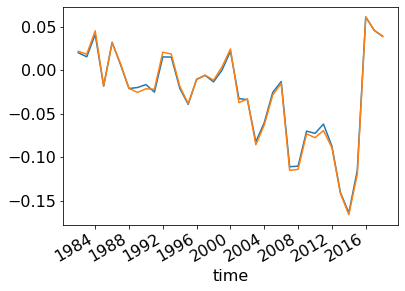

In [257]:
annual_mean_CC_SH_under80.sel(perturbation=0).plot()
annual_mean_CC_SH.sel(perturbation=0).plot()

In [29]:
print(annual_mean_CACK_NH.sel(perturbation=0, time='2016'))
print(annual_mean_CACK_SH.sel(perturbation=0, time='2016'))

<xarray.DataArray (time: 1)>
array([0.25077354])
Coordinates:
  * time     (time) datetime64[ns] 2016-01-01
<xarray.DataArray (time: 1)>
array([0.02789782])
Coordinates:
  * time     (time) datetime64[ns] 2016-01-01


In [30]:
print('CC')
print(annual_mean_CC_NH.sel(perturbation=0, time='2008')*2) #To compare with M. Flanner et al. (2011)
print(annual_mean_CC_NH.sel(perturbation=0, time='2008')*2-annual_mean_CC_NH.sel(perturbation=2, time='2008')*2)
print('CACK')
print(annual_mean_CACK_NH.sel(perturbation=0, time='2008')*2)
print(annual_mean_CACK_NH.sel(perturbation=0, time='2008')*2-annual_mean_CACK_NH.sel(perturbation=2, time='2008')*2)


CC
<xarray.DataArray (time: 1)>
array([0.3774788])
Coordinates:
  * time     (time) datetime64[ns] 2008-01-01
<xarray.DataArray (time: 1)>
array([0.19325036])
Coordinates:
  * time     (time) datetime64[ns] 2008-01-01
CACK
<xarray.DataArray (time: 1)>
array([0.29324427])
Coordinates:
  * time     (time) datetime64[ns] 2008-01-01
<xarray.DataArray (time: 1)>
array([inf])
Coordinates:
  * time     (time) datetime64[ns] 2008-01-01


In [259]:
#global 2008
print('Global CC 2008')
print(annual_mean_CC_NH.sel(perturbation=0, time='2008')) #To compare with M. Flanner et al. (2011)
print('Global CACK 2008')
print(annual_mean_CACK_NH.sel(perturbation=0, time='2008'))


Global CC 2008
<xarray.DataArray (time: 1)>
array([0.1887394])
Coordinates:
  * time     (time) datetime64[ns] 2008-01-01
Global CACK 2008
<xarray.DataArray (time: 1)>
array([0.14662214])
Coordinates:
  * time     (time) datetime64[ns] 2008-01-01


In [260]:
print(annual_mean_CC_NH.sel(perturbation=0, time='2016')) #NH peak
print(annual_mean_CACK_NH.sel(perturbation=0, time='2016'))

<xarray.DataArray (time: 1)>
array([0.33303258])
Coordinates:
  * time     (time) datetime64[ns] 2016-01-01
<xarray.DataArray (time: 1)>
array([0.25077354])
Coordinates:
  * time     (time) datetime64[ns] 2016-01-01


In [261]:
print(annual_mean_CC_SH.sel(perturbation=0, time='2014')) #SH peak
print(annual_mean_CACK_SH.sel(perturbation=0, time='2014'))

<xarray.DataArray (time: 1)>
array([-0.16626407])
Coordinates:
  * time     (time) datetime64[ns] 2014-01-01
<xarray.DataArray (time: 1)>
array([-0.17631323])
Coordinates:
  * time     (time) datetime64[ns] 2014-01-01


In [262]:
#Peak annual global mean RF during the analysis period
print((combined_NH+combined_SH).sel(time='2016'))

<xarray.DataArray (time: 1)>
array([0.33647038])
Coordinates:
  * time     (time) datetime64[ns] 2016-01-01


In [264]:
#previous decade
print((combined_NH+combined_SH).sel(time=slice('2005','2015')).mean())

<xarray.DataArray ()>
array(0.07450382)


In [178]:
#And the 2016-2018 period
print((combined_NH+combined_SH).sel(time=slice('2016','2018')).mean())

<xarray.DataArray ()>
array(0.26328876)


In [179]:
#magnitude of uncertainty
print(annual_mean_CC_SH.sel(time='2000',perturbation=0)-annual_mean_CC_SH.sel(time='2000',perturbation=1))
print(annual_mean_CC_NH.sel(time='2000',perturbation=0)-annual_mean_CC_NH.sel(time='2000',perturbation=1))

<xarray.DataArray (time: 1)>
array([-0.08016874])
Coordinates:
  * time     (time) datetime64[ns] 2000-01-01
<xarray.DataArray (time: 1)>
array([-0.09704071])
Coordinates:
  * time     (time) datetime64[ns] 2000-01-01


In [60]:
#peaks and uncertainty for two-kernel mean RF
combined_NH = (annual_mean_CC_NH.sel(perturbation=0) + annual_mean_CACK_NH.sel(perturbation=0))/2.
combined_NH_up = (annual_mean_CC_NH.sel(perturbation=1) + annual_mean_CACK_NH.sel(perturbation=1))/2.

combined_SH = (annual_mean_CC_SH.sel(perturbation=0) + annual_mean_CACK_SH.sel(perturbation=0))/2.
combined_SH_up = (annual_mean_CC_SH.sel(perturbation=1) + annual_mean_CACK_SH.sel(perturbation=1))/2.

print(combined_NH.sel(time='2016'))
print('+/-')
print((combined_NH_up-combined_NH).sel(time='2016').values)

print(combined_SH.sel(time='2014'))
print('+/-')
print((combined_SH_up-combined_SH).sel(time='2014').values)

#print((combined_SH_up-combined_SH).sel(time='2016'))
print(np.sqrt((combined_NH_up-combined_NH).sel(time='2016')**2 + (combined_SH_up-combined_SH).sel(time='2016')**2))

#print((combined_SH_dn/combined_SH).sel(time='2016'))

<xarray.DataArray (time: 1)>
array([0.29026541])
Coordinates:
  * time     (time) datetime64[ns] 2016-01-01
+/-
[0.08883197]
<xarray.DataArray (time: 1)>
array([-0.17283872])
Coordinates:
  * time     (time) datetime64[ns] 2014-01-01
+/-
[0.12019639]
<xarray.DataArray (time: 1)>
array([0.14550157])
Coordinates:
  * time     (time) datetime64[ns] 2016-01-01


In [59]:
print(annual_mean_CC_NH.sel(perturbation=0).sel(time='2016'))
print(annual_mean_CACK_NH.sel(perturbation=0).sel(time='2016'))

<xarray.DataArray (time: 1)>
array([0.33141456])
Coordinates:
  * time     (time) datetime64[ns] 2016-01-01
<xarray.DataArray (time: 1)>
array([0.24911625])
Coordinates:
  * time     (time) datetime64[ns] 2016-01-01


In [222]:
meanSI_RFs_CC_NH = []
meanSI_RFs_CACK_NH = []
Arctic_SIC = Arctic_SIC.where(Arctic_SIC<=1.0, np.nan).where(Arctic_SIC['latitude']>NH_latlimit)
for tdt in tqdm(radiative_forcing_CLARAWSA_CC_NH.time):
    #print(tdt.values)
    try:
        thisSIC = Arctic_SIC.sel(time=tdt)
    except KeyError:
        #meanSI_anoms_NH.append(xr.DataArray(np.ones(1)*np.nan, dims=['time'], coords=[('time',[tdt.time.values])]))
        meanSI_RFs_CC_NH.append(xr.DataArray(np.ones(1)*np.nan, dims=['time'], coords=[('time',[tdt.time.values])]))
        meanSI_RFs_CACK_NH.append(xr.DataArray(np.ones(1)*np.nan, dims=['time'], coords=[('time',[tdt.time.values])]))
        continue
    SI_mask = xr.where(~xr.ufuncs.isnan(thisSIC),1,np.nan)

    thisF_CC = radiative_forcing_CLARAWSA_CC_NH.sel(time=tdt, perturbation=0).where(radiative_forcing_CLARAWSA_CC_NH.latitude>NH_latlimit).fillna(fillval_RF) * SI_mask
    thisF_CACK = radiative_forcing_CLARAWSA_CACK_NH.sel(time=tdt, perturbation=0).where(radiative_forcing_CLARAWSA_CACK_NH.latitude>NH_latlimit).fillna(fillval_RF) * SI_mask
    meanSI_RFs_CC_NH.append(thisF_CC.sum(('lat', 'lon')).drop('month') * area_normalization)
    meanSI_RFs_CACK_NH.append(thisF_CACK.sum(('lat', 'lon')).drop('month') * area_normalization)

meanSI_RFs_CC_SH = []
meanSI_RFs_CACK_SH = []
for tdt in tqdm(radiative_forcing_CLARAWSA_CC_SH.time):
    #print(tdt.values)
    thisSIC = Antarctic_SIC.sel(time=tdt)
    SI_mask = xr.where(~xr.ufuncs.isnan(thisSIC),1,np.nan)
    
    thisF_CC = radiative_forcing_CLARAWSA_CC_SH.sel(time=tdt, perturbation=0).fillna(fillval_RF) * SI_mask 
    thisF_CACK = radiative_forcing_CLARAWSA_CACK_SH.sel(time=tdt, perturbation=0).fillna(fillval_RF) * SI_mask
    meanSI_RFs_CC_SH.append(thisF_CC.where(thisF_CC.latitude<SH_latlimit).sum(('lat', 'lon')).drop('month') * area_normalization)
    meanSI_RFs_CACK_SH.append(thisF_CACK.where(thisF_CACK.latitude<SH_latlimit).sum(('lat', 'lon')).drop('month') * area_normalization)                              

In [223]:
#annual mean, global effect
#mean_SI_anoms_NH_annual = xr.concat(meanSI_anoms_NH, dim='time').resample(time='AS').mean()
meanSI_RFs_CC_NH_annual = xr.concat(meanSI_RFs_CC_NH, dim='time')\
    .reindex(time=pd.date_range('01-01-1982', '31-12-'+str(stopyear), freq='MS')).resample(time='AS').mean()
meanSI_RFs_CACK_NH_annual = xr.concat(meanSI_RFs_CACK_NH, dim='time')\
    .reindex(time=pd.date_range('01-01-1982', '31-12-'+str(stopyear), freq='MS')).resample(time='AS').mean()

#meanSI_anoms_SH_annual = xr.concat(meanSI_anoms_SH, dim='time').resample(time='AS').mean()
meanSI_RFs_CC_SH_annual = xr.concat(meanSI_RFs_CC_SH, dim='time')\
    .reindex(time=pd.date_range('01-01-1982', '31-12-'+str(stopyear), freq='MS')).resample(time='AS').mean()
meanSI_RFs_CACK_SH_annual = xr.concat(meanSI_RFs_CACK_SH, dim='time')\
    .reindex(time=pd.date_range('01-01-1982', '31-12-'+str(stopyear), freq='MS')).resample(time='AS').mean()

#exclude 1982-1987 NH as Arctic sea ice record has too much coverage missing to yield reasonable SIC-RF relationships
#mean_SI_anoms_NH_annual = mean_SI_anoms_NH_annual.sel(time=slice('1988','2015'))
meanSI_RFs_CC_NH_annual = meanSI_RFs_CC_NH_annual.sel(time=slice('1988',str(stopyear)))
meanSI_RFs_CACK_NH_annual = meanSI_RFs_CACK_NH_annual.sel(time=slice('1988',str(stopyear)))

meanSI_RFs_CC_SH_annual = meanSI_RFs_CC_SH_annual#.sel(perturbation=0)
meanSI_RFs_CACK_SH_annual = meanSI_RFs_CACK_SH_annual#.sel(perturbation=0)

C:\Users\riihelaa\AppData\Local\Continuum\anaconda3\envs\scientia\lib\site-packages\xarray\core\nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


In [224]:
meanSI_RFs_CC_SH_annual

<xarray.DataArray (time: 37)>
array([ 0.02013134,  0.00690714,  0.03151737, -0.01971488,  0.03238022,
        0.0042148 , -0.02286487, -0.00587319, -0.00524079, -0.0335916 ,
       -0.0008768 ,  0.00811067, -0.0201808 , -0.03942356, -0.00531544,
       -0.0031463 , -0.01800196, -0.00925991,  0.02018363, -0.02014604,
       -0.02878994, -0.07330427, -0.05540543, -0.02052098, -0.00691458,
       -0.09994872, -0.09808418, -0.06004338, -0.06299048, -0.04912166,
       -0.08208681, -0.1325753 , -0.15547767, -0.10044864,  0.06139902,
        0.04671659,  0.04065638])
Coordinates:
  * time     (time) datetime64[ns] 1982-01-01 1983-01-01 ... 2018-01-01

In [11]:
foo = {}

for mn in np.arange(1,13):
    monthname = calendar.month_name[mn]
    sheet = monthname + '-NH'
    SI_extent_G02135 = pd.read_excel(datadriveletter+'/radiative_forcing_2020/Sea_Ice_Index_Monthly_Data_with_Statistics_G02135_v3.0.xlsx',
                                header=9, sheet_name=sheet)
    #print(SI_extent_G02135['area'][0:5])
    foo[monthname] = SI_extent_G02135['extent'][0:41].values
SI_areas_NH = pd.DataFrame(index=np.arange(1979,2020), data=foo)

bar = {}

for mn in np.arange(1,13):
    monthname = calendar.month_name[mn]
    sheet = monthname + '-SH'
    SI_extent_G02135 = pd.read_excel(datadriveletter+'/radiative_forcing_2020/Sea_Ice_Index_Monthly_Data_with_Statistics_G02135_v3.0.xlsx',
                                header=9, sheet_name=sheet)
    #print(SI_extent_G02135['area'][0:5])
    bar[monthname] = SI_extent_G02135['extent'][0:41].values
SI_areas_SH = pd.DataFrame(index=np.arange(1979,2020), data=bar)

In [377]:
print(meanSI_RFs_CC_SH_annual_crop.sel(time=slice('2013','2015')).mean())
print(meanSI_RFs_CC_SH_annual_crop.sel(time='2014'))


<xarray.DataArray ()>
array(-0.12556181)
<xarray.DataArray (time: 1)>
array([-0.14935886])
Coordinates:
  * time     (time) datetime64[ns] 2014-01-01


C:\Users\riihelaa\AppData\Local\Continuum\anaconda3\envs\scientia\lib\site-packages\xarray\core\nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


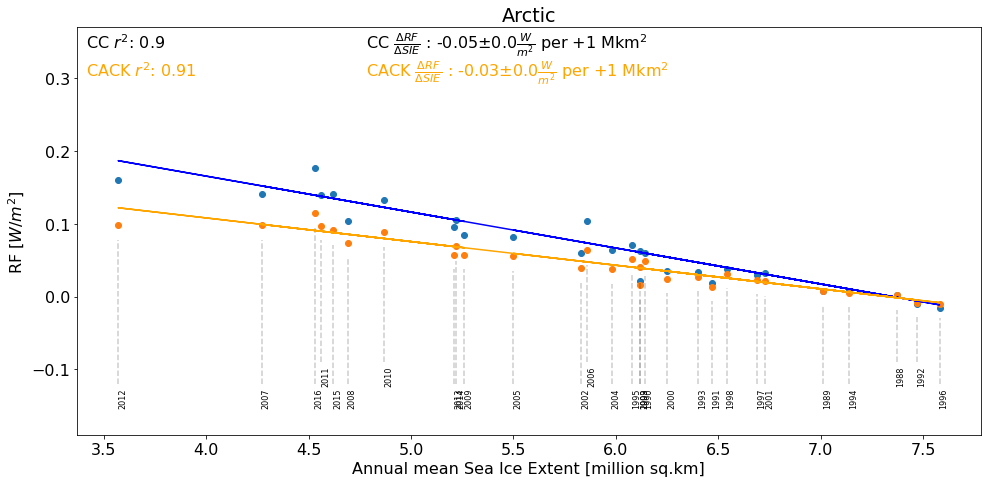

In [225]:
#For a quick comparison with Pistone et al., 2019 - what the RF associated with NH sea ice loss between 1979-2016 
#from the regression lines? Note lat limit of 60N
meanSI_RFs_CC_NH = []
meanSI_RFs_CACK_NH = []
Arctic_SIC_formask = Arctic_SIC.where(Arctic_SIC<=1.0, np.nan).where(Arctic_SIC['latitude']>NH_latlimit)

for tdt in tqdm(radiative_forcing_CLARAWSA_CC_NH.time):
    #print(tdt.values)
    try:
        thisSIC = Arctic_SIC_formask.sel(time=tdt)
    except KeyError:
        #meanSI_anoms_NH.append(xr.DataArray(np.ones(1)*np.nan, dims=['time'], coords=[('time',[tdt.time.values])]))
        meanSI_RFs_CC_NH.append(xr.DataArray(np.ones(1)*np.nan, dims=['time'], coords=[('time',[tdt.time.values])]))
        meanSI_RFs_CACK_NH.append(xr.DataArray(np.ones(1)*np.nan, dims=['time'], coords=[('time',[tdt.time.values])]))
        continue
    SI_mask = xr.where(~xr.ufuncs.isnan(thisSIC),1,np.nan)

    thisF_CC = radiative_forcing_CLARAWSA_CC_NH.sel(time=tdt, perturbation=0).where(radiative_forcing_CLARAWSA_CC_NH.latitude>60).fillna(fillval_RF) * SI_mask
    thisF_CACK = radiative_forcing_CLARAWSA_CACK_NH.sel(time=tdt, perturbation=0).where(radiative_forcing_CLARAWSA_CACK_NH.latitude>60).fillna(fillval_RF) * SI_mask
    meanSI_RFs_CC_NH.append(thisF_CC.sum(('lat', 'lon')).drop('month') * area_normalization)
    meanSI_RFs_CACK_NH.append(thisF_CACK.sum(('lat', 'lon')).drop('month') * area_normalization)

meanSI_RFs_CC_NH_annual = xr.concat(meanSI_RFs_CC_NH, dim='time')\
    .reindex(time=pd.date_range('01-01-1982', '31-12-'+str(stopyear), freq='MS')).resample(time='AS').mean()
meanSI_RFs_CACK_NH_annual = xr.concat(meanSI_RFs_CACK_NH, dim='time')\
    .reindex(time=pd.date_range('01-01-1982', '31-12-'+str(stopyear), freq='MS')).resample(time='AS').mean()

#meanSI_RFs_CC_NH_annual = meanSI_RFs_CC_NH_annual.sel(time=slice('1988',str(stopyear)))
#meanSI_RFs_CACK_NH_annual = meanSI_RFs_CACK_NH_annual.sel(time=slice('1988',str(stopyear)))


SI_areas_NH_sunlit = SI_areas_NH[['March','April', 'May', 'June', 'July', 'August', 'September']].min(axis=1).loc['1988':'2016']
meanSI_RFs_CC_NH_annual = meanSI_RFs_CC_NH_annual.sel(time=slice('1988','2016'))
meanSI_RFs_CACK_NH_annual = meanSI_RFs_CACK_NH_annual.sel(time=slice('1988','2016'))

###NH###
#plt.subplot(121)
plt.figure(figsize=(14,7))
plt.scatter(SI_areas_NH_sunlit, meanSI_RFs_CC_NH_annual)
plt.scatter(SI_areas_NH_sunlit, meanSI_RFs_CACK_NH_annual)
uplifted = [2011,2010,2006,1988,1992]
for i, txt in enumerate(meanSI_RFs_CC_NH_annual.time):
    if (i+1988) in uplifted:
        shift = 0.03
    else:
        shift = 0
    plt.annotate(pd.to_datetime(txt.values).strftime('%Y'), \
                 (SI_areas_NH_sunlit.values[i], \
                  -0.15+shift), fontsize=8, rotation=90)
    plt.vlines(SI_areas_NH_sunlit.values[i], -.12+shift, meanSI_RFs_CACK_NH_annual[i]-0.02, linestyle='--', alpha=0.2)
    
slope_CC_NH_extent, icpt_CC_NH_extent, lo_slope_CC_NH_extent, hi_slope_CC_NH_extent = theilslopes(meanSI_RFs_CC_NH_annual, \
                                                                      SI_areas_NH_sunlit, alpha=0.95)
slope_CACK_NH_extent, icpt_CACK_NH_extent, lo_slope_CACK_NH_extent, hi_slope_CACK_NH_extent = theilslopes(meanSI_RFs_CACK_NH_annual, \
                                                                              SI_areas_NH_sunlit, alpha=0.95)
fitted_CC_NH_extent = SI_areas_NH_sunlit * slope_CC_NH_extent + icpt_CC_NH_extent
fitted_CACK_NH_extent = SI_areas_NH_sunlit * slope_CACK_NH_extent + icpt_CACK_NH_extent

plusminus_CC_NH_extent = slope_CC_NH_extent-lo_slope_CC_NH_extent
plusminus_CACK_NH_extent = slope_CACK_NH_extent-lo_slope_CACK_NH_extent


plt.text(0.01,  0.95, 'CC $r^2$: ' + str(np.round(r2_score(meanSI_RFs_CC_NH_annual, fitted_CC_NH_extent),2)), transform=plt.gca().transAxes)
plt.text(0.01,  0.88, 'CACK $r^2$: ' + str(np.round(r2_score(meanSI_RFs_CACK_NH_annual, fitted_CACK_NH_extent),2)), transform=plt.gca().transAxes, color='orange')

plt.text(0.32,  0.95, r'CC $ \frac{\Delta RF}{\Delta SIE}$ : ' + str(np.round(slope_CC_NH_extent,2)) + \
         r'$\pm$' + str(np.round(plusminus_CC_NH_extent,2)) + \
         r'$ \frac{W}{m^2} $' + \
         ' per +1 Mkm$^2$', transform=plt.gca().transAxes)
plt.text(0.32,  0.88, r'CACK $ \frac{\Delta RF}{\Delta SIE}$ : ' + str(np.round(slope_CACK_NH_extent,2)) + \
         r'$\pm$' + str(np.round(plusminus_CACK_NH_extent,2)) + \
         r'$ \frac{W}{m^2} $' + \
         ' per +1 Mkm$^2$', transform=plt.gca().transAxes, color='orange')


plt.plot(SI_areas_NH_sunlit, fitted_CC_NH_extent, linestyle='-', color='blue' )
plt.plot(SI_areas_NH_sunlit, fitted_CACK_NH_extent, linestyle='-', color='orange' )
plt.xlabel('Annual mean Sea Ice Extent [million sq.km]')
plt.ylabel('RF [$W/m^2$]')
plt.title('Arctic')
plt.ylim(-.19, .37)
plt.tight_layout()

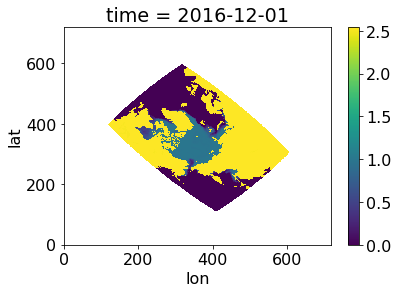

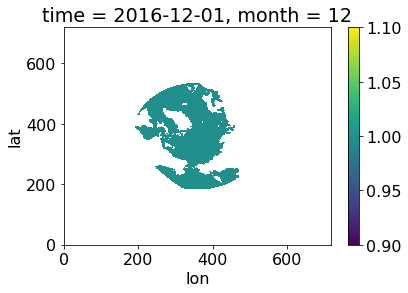

In [151]:
Arctic_SIC.sel(time='2016-12-01').plot()
plt.show()

#SI_mask = xr.where(~xr.ufuncs.isnan(Arctic_SIC.sel(time='2016-05-01')),1,np.nan)
SI_mask.plot()

In [226]:
SI_areas_NH_sunlit = SI_areas_NH[['March','April', 'May', 'June', 'July', 'August', 'September']].min(axis=1)
print('CC RF from 1979-2016 SIE changes, poleward of 60N')
print((SI_areas_NH_sunlit[2016]-SI_areas_NH_sunlit[2000])*slope_CC_NH_extent)

print('CACK RF from 1979-2016 SIE changes, poleward of 60N')
print((SI_areas_NH_sunlit[2016]-SI_areas_NH_sunlit[2000])*slope_CACK_NH_extent)


CC RF from 1979-2016 SIE changes, poleward of 60N
0.0849979824952644
CACK RF from 1979-2016 SIE changes, poleward of 60N
0.055920014833737014


C:\Users\riihelaa\AppData\Local\Continuum\anaconda3\envs\scientia\lib\site-packages\xarray\core\nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


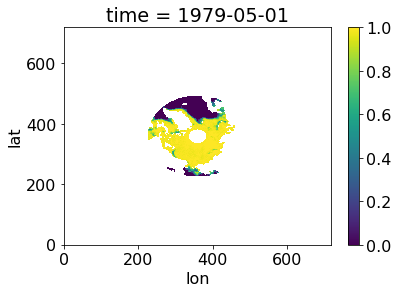

In [142]:
Arctic_SIC_Pistone = Arctic_SIC.where(Arctic_SIC<=1.0, np.nan).where(Arctic_SIC['latitude']>60)
Arctic_SIC_Pistone[6,:,:].plot()
Arctic_SIC_Pistone = Arctic_SIC_Pistone.mean(('lat','lon'))

In [227]:
def is_sunlit(month):
    return (month >= 4) & (month <= 8)
Arctic_SIC_sunlit = Arctic_SIC_Pistone.sel(time=is_sunlit(Arctic_SIC.time.dt.month))

In [228]:
Arctic_SIC_sunlit = Arctic_SIC_sunlit.resample(time='AS').mean()

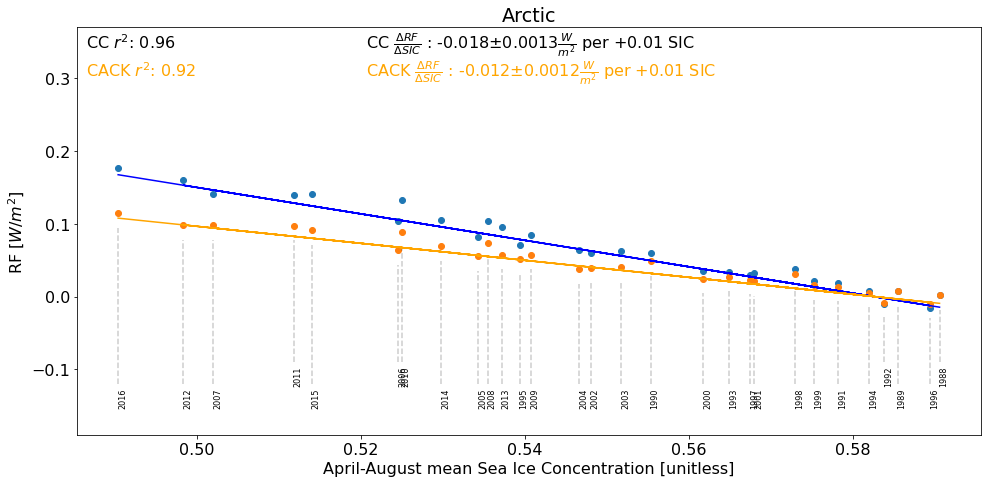

In [229]:
Arctic_SIC_sunlit_crop = Arctic_SIC_sunlit.sel(time=slice('1988','2016'))
meanSI_RFs_CC_NH_annual = meanSI_RFs_CC_NH_annual.sel(time=slice('1988','2016'))
meanSI_RFs_CACK_NH_annual = meanSI_RFs_CACK_NH_annual.sel(time=slice('1988','2016'))

###NH###
#plt.subplot(121)
plt.figure(figsize=(14,7))
plt.scatter(Arctic_SIC_sunlit_crop, meanSI_RFs_CC_NH_annual)
plt.scatter(Arctic_SIC_sunlit_crop, meanSI_RFs_CACK_NH_annual)
uplifted = [2011,2010,2006,1988,1992]
for i, txt in enumerate(meanSI_RFs_CC_NH_annual.time):
    if (i+1988) in uplifted:
        shift = 0.03
    else:
        shift = 0
    plt.annotate(pd.to_datetime(txt.values).strftime('%Y'), \
                 (Arctic_SIC_sunlit_crop.values[i], \
                  -0.15+shift), fontsize=8, rotation=90)
    plt.vlines(Arctic_SIC_sunlit_crop.values[i], -.12+shift, meanSI_RFs_CACK_NH_annual[i]-0.02, linestyle='--', alpha=0.2)
    
slope_CC_NH_SIC, icpt_CC_NH_SIC, lo_slope_CC_NH_SIC, hi_slope_CC_NH_SIC = theilslopes(meanSI_RFs_CC_NH_annual, \
                                                                      Arctic_SIC_sunlit_crop, alpha=0.95)
slope_CACK_NH_SIC, icpt_CACK_NH_SIC, lo_slope_CACK_NH_SIC, hi_slope_CACK_NH_SIC = theilslopes(meanSI_RFs_CACK_NH_annual, \
                                                                              Arctic_SIC_sunlit_crop, alpha=0.95)
fitted_CC_NH_SIC = Arctic_SIC_sunlit_crop * slope_CC_NH_SIC + icpt_CC_NH_SIC
fitted_CACK_NH_SIC = Arctic_SIC_sunlit_crop * slope_CACK_NH_SIC + icpt_CACK_NH_SIC

plusminus_CC_NH_SIC = slope_CC_NH_SIC-lo_slope_CC_NH_SIC
plusminus_CACK_NH_SIC = slope_CACK_NH_SIC-lo_slope_CACK_NH_SIC


plt.text(0.01,  0.95, 'CC $r^2$: ' + str(np.round(r2_score(meanSI_RFs_CC_NH_annual, fitted_CC_NH_SIC),2)), transform=plt.gca().transAxes)
plt.text(0.01,  0.88, 'CACK $r^2$: ' + str(np.round(r2_score(meanSI_RFs_CACK_NH_annual, fitted_CACK_NH_SIC),2)), transform=plt.gca().transAxes, color='orange')

plt.text(0.32,  0.95, r'CC $ \frac{\Delta RF}{\Delta SIC}$ : ' + str(np.round(slope_CC_NH_SIC/100.,3)) + \
         r'$\pm$' + str(np.round(plusminus_CC_NH_SIC/100.,4)) + \
         r'$ \frac{W}{m^2} $' + \
         ' per +0.01 SIC', transform=plt.gca().transAxes)
plt.text(0.32,  0.88, r'CACK $ \frac{\Delta RF}{\Delta SIC}$ : ' + str(np.round(slope_CACK_NH_SIC/100.,3)) + \
         r'$\pm$' + str(np.round(plusminus_CACK_NH_SIC/100.,4)) + \
         r'$ \frac{W}{m^2} $' + \
         ' per +0.01 SIC', transform=plt.gca().transAxes, color='orange')


plt.plot(Arctic_SIC_sunlit_crop, fitted_CC_NH_SIC, linestyle='-', color='blue' )
plt.plot(Arctic_SIC_sunlit_crop, fitted_CACK_NH_SIC, linestyle='-', color='orange' )
plt.xlabel('April-August mean Sea Ice Concentration [unitless]')
plt.ylabel('RF [$W/m^2$]')
plt.title('Arctic')
plt.ylim(-.19, .37)
plt.tight_layout()

In [230]:
#For 1979-2016
print('CC RF from sea ice loss between 2000-2016:')
print((Arctic_SIC_sunlit.sel(time='2016').values-Arctic_SIC_sunlit.sel(time='2000').values) * slope_CC_NH_SIC)

print('CACK RF from sea ice loss between 2000-2016:')
print((Arctic_SIC_sunlit.sel(time='2016').values-Arctic_SIC_sunlit.sel(time='2000').values) * slope_CACK_NH_SIC)

CC RF from sea ice loss between 2000-2016:
[0.12963636]
CACK RF from sea ice loss between 2000-2016:
[0.08336884]


In [231]:
icpt_CC_NH_SIC

1.0590066854388536

In [232]:
icpt_CACK_NH_SIC

0.6811331212950218

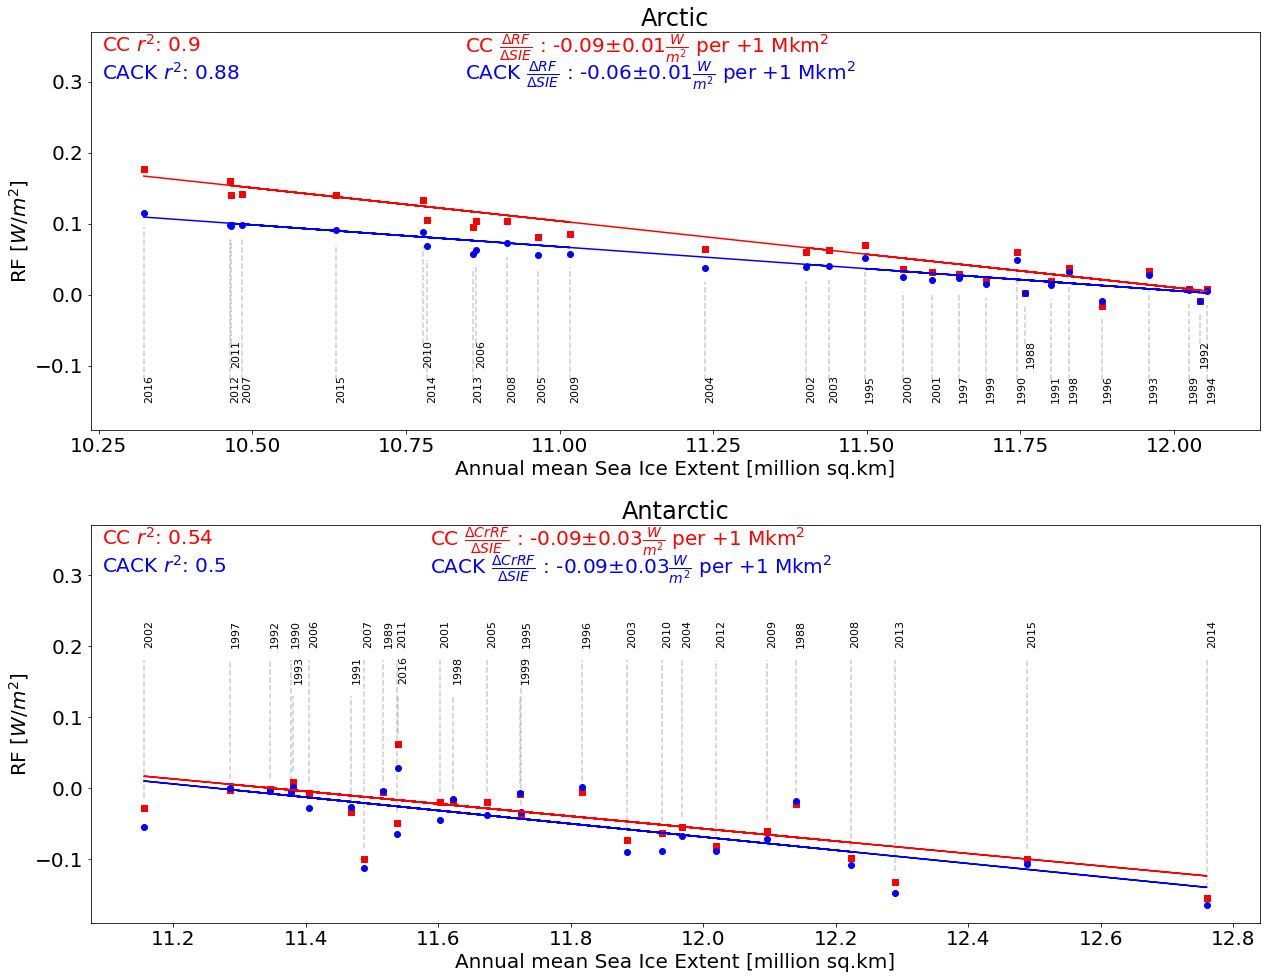

In [250]:
meanSI_RFs_CC_SH_annual = meanSI_RFs_CC_SH_annual.sel(time=slice('1988','2016'))
meanSI_RFs_CACK_SH_annual = meanSI_RFs_CACK_SH_annual.sel(time=slice('1988','2016'))

meanSI_RFs_CC_NH_annual = meanSI_RFs_CC_NH_annual.sel(time=slice('1988','2016'))
meanSI_RFs_CACK_NH_annual = meanSI_RFs_CACK_NH_annual.sel(time=slice('1988','2016'))


SH_extent_annual = SI_areas_SH.mean(axis=1).loc['1988':'2016']
NH_extent_annual = SI_areas_NH.mean(axis=1).loc['1988':'2016']

SH_extent_annual = SH_extent_annual.drop([1994,2000])
meanSI_RFs_CC_SH_annual_crop = meanSI_RFs_CC_SH_annual.drop_sel(time=[pd.to_datetime('1994-01-01'), pd.to_datetime('2000-01-01')])
meanSI_RFs_CACK_SH_annual_crop = meanSI_RFs_CACK_SH_annual.drop_sel(time=[pd.to_datetime('1994-01-01'), pd.to_datetime('2000-01-01')])



f=plt.figure(figsize=(18,14))
###SH###
plt.subplot(212)

plt.scatter(SH_extent_annual, meanSI_RFs_CC_SH_annual_crop, color='red', marker='s')
plt.scatter(SH_extent_annual, meanSI_RFs_CACK_SH_annual_crop, color='blue')
downpressed = [1993,1999,1991, 1998, 2016]
for i, txt in enumerate(meanSI_RFs_CC_SH_annual_crop.time):
    if txt.dt.year in downpressed:
        shift = -0.05
    else:
        shift = 0    
    plt.annotate(pd.to_datetime(txt.values).strftime('%Y'), \
                 (SH_extent_annual.values[i], \
                  0.2+shift), fontsize=11, rotation=90)
    plt.vlines(SH_extent_annual.values[i], meanSI_RFs_CC_SH_annual_crop[i].values+0.015, 0.18+shift, linestyle='--', alpha=0.2)
    
slope_CC_SH_extent, icpt_CC_SH_extent, lo_slope_CC_SH_extent, hi_slope_CC_SH_extent = theilslopes(meanSI_RFs_CC_SH_annual_crop, \
                                                                      SH_extent_annual, alpha=0.95)
slope_CACK_SH_extent, icpt_CACK_SH_extent, lo_slope_CACK_SH_extent, hi_slope_CACK_SH_extent = theilslopes(meanSI_RFs_CACK_SH_annual_crop, \
                                                                              SH_extent_annual, alpha=0.95)
fitted_CC_SH_extent = SH_extent_annual * slope_CC_SH_extent + icpt_CC_SH_extent
fitted_CACK_SH_extent = SH_extent_annual * slope_CACK_SH_extent + icpt_CACK_SH_extent

plusminus_CC_SH_extent = slope_CC_SH_extent-lo_slope_CC_SH_extent
plusminus_CACK_SH_extent = slope_CACK_SH_extent-lo_slope_CACK_SH_extent

plt.text(0.01,  0.95, 'CC $r^2$: ' + str(np.round(r2_score(meanSI_RFs_CC_SH_annual_crop, fitted_CC_SH_extent),2)), transform=plt.gca().transAxes, color='red')
plt.text(0.01,  0.88, 'CACK $r^2$: ' + str(np.round(r2_score(meanSI_RFs_CACK_SH_annual_crop, fitted_CACK_SH_extent),2)), transform=plt.gca().transAxes, color='blue')

plt.plot(SH_extent_annual, fitted_CC_SH_extent, linestyle='-', color='red' )
plt.plot(SH_extent_annual, fitted_CACK_SH_extent, linestyle='-', color='blue' )

plt.text(0.29,  0.95, r'CC $ \frac{\Delta CrRF}{\Delta SIE}$ : ' + str(np.round(slope_CC_SH_extent,2)) + \
         r'$\pm$' + str(np.round(plusminus_CC_SH_extent,2)) + \
         r'$ \frac{W}{m^2} $' + \
         ' per +1 Mkm$^2$', transform=plt.gca().transAxes, color='red')
plt.text(0.29,  0.88, r'CACK $ \frac{\Delta CrRF}{\Delta SIE}$ : ' + str(np.round(slope_CACK_SH_extent,2)) + \
         r'$\pm$' + str(np.round(plusminus_CACK_SH_extent,2)) + \
         r'$ \frac{W}{m^2} $' + \
         ' per +1 Mkm$^2$', transform=plt.gca().transAxes, color='blue')

plt.xlabel('Annual mean Sea Ice Extent [million sq.km]')
plt.title('Antarctic')
plt.ylim(-.19, .37)
plt.ylabel('RF [$W/m^2$]')

###NH###
plt.subplot(211)

plt.scatter(NH_extent_annual, meanSI_RFs_CC_NH_annual, color='red', marker='s')
plt.scatter(NH_extent_annual, meanSI_RFs_CACK_NH_annual, color='blue')
uplifted = [2011,2010,2006,1988,1992]
for i, txt in enumerate(meanSI_RFs_CC_NH_annual.time):
    if (i+1988) in uplifted:
        shift = 0.05
    else:
        shift = 0
    plt.annotate(pd.to_datetime(txt.values).strftime('%Y'), \
                 (NH_extent_annual.values[i], \
                  -0.15+shift), fontsize=11, rotation=90)
    plt.vlines(NH_extent_annual.values[i], -.12+shift, meanSI_RFs_CACK_NH_annual[i]-0.02, linestyle='--', alpha=0.2)
    
slope_CC_NH_extent, icpt_CC_NH_extent, lo_slope_CC_NH_extent, hi_slope_CC_NH_extent = theilslopes(meanSI_RFs_CC_NH_annual, \
                                                                      NH_extent_annual, alpha=0.95)
slope_CACK_NH_extent, icpt_CACK_NH_extent, lo_slope_CACK_NH_extent, hi_slope_CACK_NH_extent = theilslopes(meanSI_RFs_CACK_NH_annual, \
                                                                              NH_extent_annual, alpha=0.95)
fitted_CC_NH_extent = NH_extent_annual * slope_CC_NH_extent + icpt_CC_NH_extent
fitted_CACK_NH_extent = NH_extent_annual * slope_CACK_NH_extent + icpt_CACK_NH_extent

plusminus_CC_NH_extent = slope_CC_NH_extent-lo_slope_CC_NH_extent
plusminus_CACK_NH_extent = slope_CACK_NH_extent-lo_slope_CACK_NH_extent


plt.text(0.01,  0.95, 'CC $r^2$: ' + str(np.round(r2_score(meanSI_RFs_CC_NH_annual, fitted_CC_NH_extent),2)), transform=plt.gca().transAxes, color='red')
plt.text(0.01,  0.88, 'CACK $r^2$: ' + str(np.round(r2_score(meanSI_RFs_CACK_NH_annual, fitted_CACK_NH_extent),2)), transform=plt.gca().transAxes, color='blue')

plt.text(0.32,  0.95, r'CC $ \frac{\Delta RF}{\Delta SIE}$ : ' + str(np.round(slope_CC_NH_extent,2)) + \
         r'$\pm$' + str(np.round(plusminus_CC_NH_extent,2)) + \
         r'$ \frac{W}{m^2} $' + \
         ' per +1 Mkm$^2$', transform=plt.gca().transAxes, color='red')
plt.text(0.32,  0.88, r'CACK $ \frac{\Delta RF}{\Delta SIE}$ : ' + str(np.round(slope_CACK_NH_extent,2)) + \
         r'$\pm$' + str(np.round(plusminus_CACK_NH_extent,2)) + \
         r'$ \frac{W}{m^2} $' + \
         ' per +1 Mkm$^2$', transform=plt.gca().transAxes, color='blue')


plt.plot(NH_extent_annual, fitted_CC_NH_extent, linestyle='-', color='red' )
plt.plot(NH_extent_annual, fitted_CACK_NH_extent, linestyle='-', color='blue' )
plt.xlabel('Annual mean Sea Ice Extent [million sq.km]')
plt.ylabel('RF [$W/m^2$]')
plt.title('Arctic')
plt.ylim(-.19, .37)
plt.tight_layout()
plt.savefig(figure_dir + 'Supplementary_Figure_RF_SIE_landscape.png', dpi=300)
plt.savefig(figure_dir + 'Supplementary_Figure_RF_SIE_landscape.pdf', dpi=300)
plt.show()

In [572]:
meanSI_RFs_CACK_SH_annual

<xarray.DataArray (time: 29)>
array([-0.01871039, -0.00304764, -0.00292   , -0.0259041 , -0.00166812,
        0.0022062 , -0.02133723, -0.03193886,  0.0006451 ,  0.00388786,
       -0.01311281, -0.00647103,  0.01822804, -0.04393374, -0.05323038,
       -0.08756722, -0.06582987, -0.03775129, -0.02715594, -0.1106435 ,
       -0.10699019, -0.06976425, -0.08729794, -0.06287226, -0.0862656 ,
       -0.14272424, -0.15857318, -0.10473083,  0.03001151])
Coordinates:
  * time     (time) datetime64[ns] 1988-01-01 1989-01-01 ... 2016-01-01

In [220]:
## second supplementary figure, RF vs SIC
Arctic_SIC = Arctic_SIC.where(Arctic_SIC<=1.0, np.nan).where(Arctic_SIC['latitude']>NH_latlimit)
Antarctic_SIC = Antarctic_SIC.where(Antarctic_SIC<=1.0, np.nan).where(Antarctic_SIC['latitude']<SH_latlimit)

#How well do the RF changes correlate with SIC anomalies vs. baseline?
#Antarctic_SIC_baseline = Antarctic_SIC.sel(time=slice('1982','1991')).mean(('lat','lon','time'))
Antarctic_SIC_baseline = Antarctic_SIC.sel(time=slice('1982','1991'))
Antarctic_SIC_baseline = Antarctic_SIC_baseline.groupby(Antarctic_SIC_baseline.time.dt.month).mean('time').compute()

#Arctic_SIC_baseline = Arctic_SIC.sel(time=slice('1982','1991')).mean(('lat','lon','time'))
Arctic_SIC_baseline = Arctic_SIC.sel(time=slice('1982','1991'))
Arctic_SIC_baseline = Arctic_SIC_baseline.groupby(Arctic_SIC_baseline.time.dt.month).mean('time').compute()

#Arctic_SIC_annual_anomaly = Arctic_SIC.mean(('lat','lon')).resample(time='AS').mean()-Arctic_SIC_baseline
#Antarctic_SIC_annual_anomaly = Antarctic_SIC.mean(('lat','lon')).resample(time='AS').mean()-Antarctic_SIC_baseline

meanSI_anoms_NH = []
meanSI_RFs_CC_NH = []
meanSI_RFs_CACK_NH = []

for tdt in tqdm(radiative_forcing_CLARAWSA_CC_NH.time):
    #print(tdt.values)
    thisF_CC = radiative_forcing_CLARAWSA_CC_NH.sel(time=tdt, perturbation=0).fillna(fillval_RF)
    thisF_CACK = radiative_forcing_CLARAWSA_CACK_NH.sel(time=tdt, perturbation=0).fillna(fillval_RF)
    try:
        thisSIC = Arctic_SIC.sel(time=tdt)
    except KeyError:
        meanSI_anoms_NH.append(xr.DataArray(np.ones(1)*np.nan, dims=['time'], coords=[('time',[tdt.time.values])]))
        meanSI_RFs_CC_NH.append(xr.DataArray(np.ones(1)*np.nan, dims=['time'], coords=[('time',[tdt.time.values])]))
        meanSI_RFs_CACK_NH.append(xr.DataArray(np.ones(1)*np.nan, dims=['time'], coords=[('time',[tdt.time.values])]))
        continue
    thisSIC_BL = Arctic_SIC_baseline.sel(month=tdt.time.dt.month)
    #SI_mask = Arctic_SIregion_mask_xr.sel(time=tdt)
    #SI_mask = SI_mask.where(SI_mask>SIC_threshold, np.nan)
    #SI_mask = SI_mask.where(SI_mask.isnull(),1.0)
    SI_mask = xr.where(~xr.ufuncs.isnan(thisSIC),1,np.nan)
    
    SI_anomaly = thisSIC-thisSIC_BL
    thisF_CC_SI = thisF_CC.where(thisF_CC['latitude']>NH_latlimit) * SI_mask
    thisF_CACK_SI = thisF_CACK.where(thisF_CC['latitude']>NH_latlimit) * SI_mask
    meanSI_anoms_NH.append(SI_anomaly.squeeze().mean(('lat','lon')).drop('month').rename('SIC'))
    meanSI_RFs_CC_NH.append(thisF_CC_SI.sum(('lat','lon')).drop('month').rename('RF_CC_NH')*area_normalization)
    meanSI_RFs_CACK_NH.append(thisF_CACK_SI.sum(('lat','lon')).drop('month').rename('RF_CACK_NH')*area_normalization)

meanSI_anoms_SH = []
meanSI_RFs_CC_SH = []
meanSI_RFs_CACK_SH = []

for tdt in tqdm(radiative_forcing_CLARAWSA_CC_SH.time):
    #print(tdt.values)
    thisF_CC = radiative_forcing_CLARAWSA_CC_SH.sel(time=tdt, perturbation=0).fillna(fillval_RF)
    thisF_CACK = radiative_forcing_CLARAWSA_CACK_SH.sel(time=tdt, perturbation=0).fillna(fillval_RF)
    thisSIC = Antarctic_SIC.sel(time=tdt)
    thisSIC_BL = Antarctic_SIC_baseline.sel(month=Antarctic_SIC_baseline.month==tdt.time.dt.month)
    #SI_mask = Antarctica_SIregion_mask_xr.sel(time=tdt)
    #SI_mask = SI_mask.where(SI_mask>SIC_threshold, np.nan)
    #SI_mask = SI_mask.where(SI_mask.isnull(),1.0)
    SI_mask = xr.where(~xr.ufuncs.isnan(thisSIC),1,np.nan)
    
    SI_anomaly = thisSIC-thisSIC_BL
    thisF_CC_SI = thisF_CC.where(thisF_CC['latitude']<SH_latlimit) * SI_mask
    thisF_CACK_SI = thisF_CACK.where(thisF_CC['latitude']<SH_latlimit) * SI_mask
    #thisF_CC_SI = thisF_CC.where((SI_anomaly!=0) & (~np.isnan(SI_anomaly)) & (thisSIC_BL<=1.))
    #thisF_CACK_SI = thisF_CACK.where((SI_anomaly!=0) & (~np.isnan(SI_anomaly)) & (thisSIC_BL<=1.))
    meanSI_anoms_SH.append(SI_anomaly.squeeze().mean(('lat','lon')).drop('month').rename('SIC'))
    meanSI_RFs_CC_SH.append(thisF_CC_SI.sum(('lat','lon')).drop('month').rename('RF_CC_SH')*area_normalization)
    meanSI_RFs_CACK_SH.append(thisF_CACK_SI.sum(('lat','lon')).drop('month').rename('RF_CACK_SH')*area_normalization) 



C:\Users\riihelaa\AppData\Local\Continuum\anaconda3\envs\scientia\lib\site-packages\xarray\core\common.py:664: FutureWarning: This DataArray contains multi-dimensional coordinates. In the future, the dimension order of these coordinates will be restored as well unless you specify restore_coord_dims=False.
  self, group, squeeze=squeeze, restore_coord_dims=restore_coord_dims
C:\Users\riihelaa\AppData\Local\Continuum\anaconda3\envs\scientia\lib\site-packages\xarray\core\nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


C:\Users\riihelaa\AppData\Local\Continuum\anaconda3\envs\scientia\lib\site-packages\xarray\core\nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


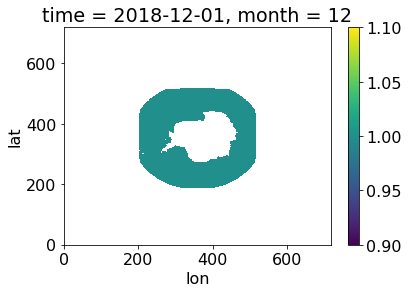

In [239]:
SI_mask.plot()

In [376]:
print(meanSI_RFs_CC_SH_annual_SIC_crop.sel(time=slice('2013','2015')).mean())
print(meanSI_RFs_CC_SH_annual_SIC_crop.sel(time='2014'))

<xarray.DataArray ()>
array(-0.12556181)
<xarray.DataArray (time: 1)>
array([-0.14935886])
Coordinates:
  * time     (time) datetime64[ns] 2014-01-01


C:\Users\riihelaa\AppData\Local\Continuum\anaconda3\envs\scientia\lib\site-packages\xarray\core\nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


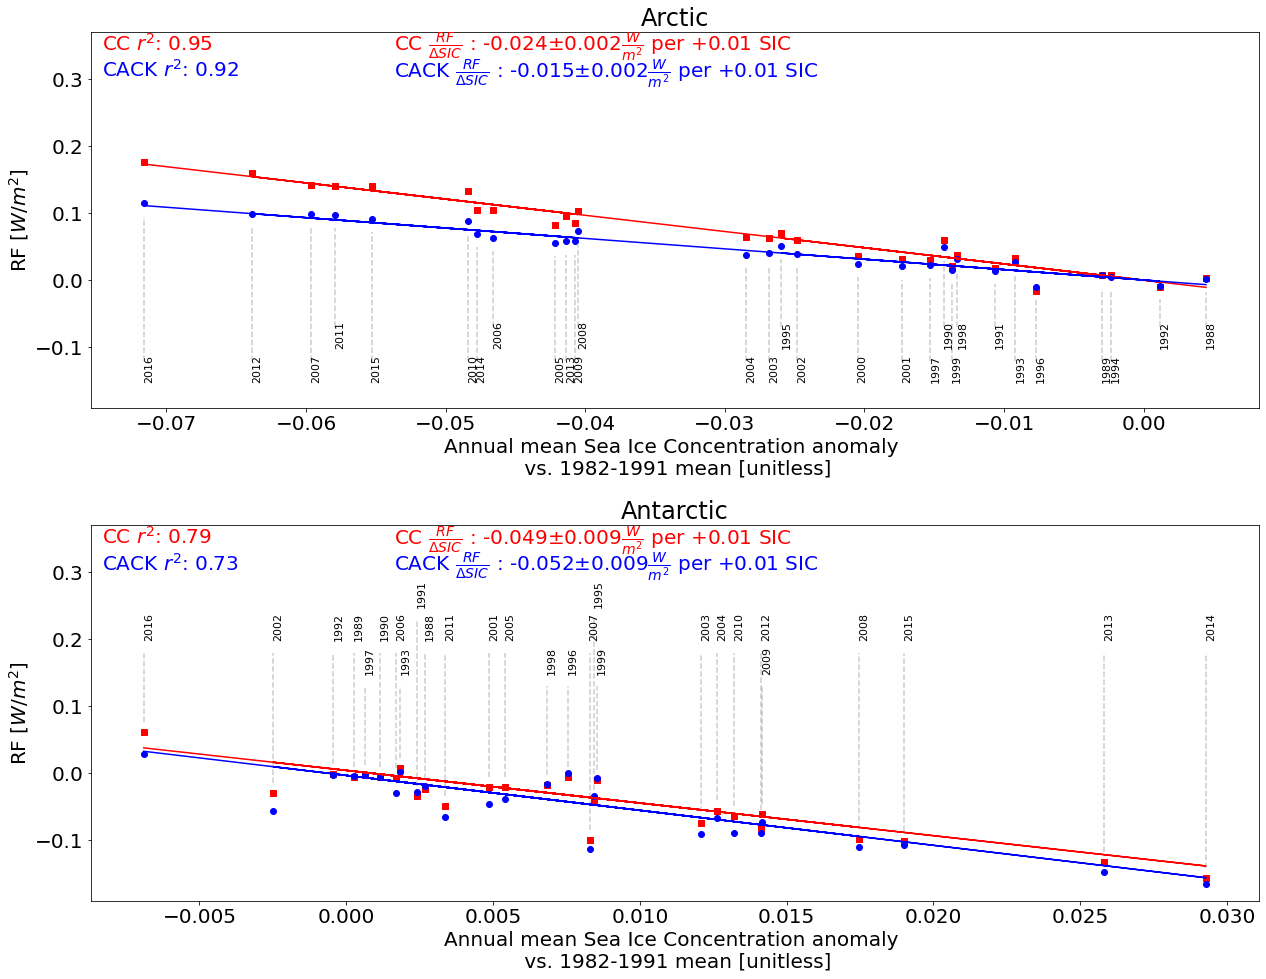

In [249]:
plt.rcParams.update({'font.size': 20})

#Arctic_SIC_annual_anomaly = Arctic_SIC_annual_anomaly.sel(time=slice('1988','2016'))
#Antarctic_SIC_annual_anomaly = Antarctic_SIC_annual_anomaly.sel(time=slice('1988','2016'))

Arctic_SIC_annual_anomaly = xr.concat(meanSI_anoms_NH, dim='time').resample(time='AS').mean().sel(time=slice('1988','2016'))
Antarctic_SIC_annual_anomaly = xr.concat(meanSI_anoms_SH, dim='time').resample(time='AS').mean().sel(time=slice('1988','2016'))

meanSI_RFs_CC_NH_annual_SIC = xr.concat(meanSI_RFs_CC_NH, dim='time').resample(time='AS').mean().sel(time=slice('1988','2016'))
meanSI_RFs_CC_SH_annual_SIC = xr.concat(meanSI_RFs_CC_SH, dim='time').resample(time='AS').mean().sel(time=slice('1988','2016'))

meanSI_RFs_CACK_NH_annual_SIC = xr.concat(meanSI_RFs_CACK_NH, dim='time').resample(time='AS').mean().sel(time=slice('1988','2016'))
meanSI_RFs_CACK_SH_annual_SIC = xr.concat(meanSI_RFs_CACK_SH, dim='time').resample(time='AS').mean().sel(time=slice('1988','2016'))

#drop 1984,1994, 2000 from SH because of potentially large missing RF
Antarctic_SIC_annual_anomaly_crop = Antarctic_SIC_annual_anomaly.drop_sel(time=[pd.to_datetime('1994-01-01'), pd.to_datetime('2000-01-01')])
meanSI_RFs_CC_SH_annual_SIC_crop = meanSI_RFs_CC_SH_annual_SIC.drop_sel(time=[pd.to_datetime('1994-01-01'), pd.to_datetime('2000-01-01')])
meanSI_RFs_CACK_SH_annual_SIC_crop = meanSI_RFs_CACK_SH_annual_SIC.drop_sel(time=[pd.to_datetime('1994-01-01'), pd.to_datetime('2000-01-01')])

f=plt.figure(figsize=(18,14))
###SH###
plt.subplot(212)

plt.scatter(Antarctic_SIC_annual_anomaly_crop, meanSI_RFs_CC_SH_annual_SIC_crop, color='red', marker='s')
plt.scatter(Antarctic_SIC_annual_anomaly_crop, meanSI_RFs_CACK_SH_annual_SIC_crop, color='blue')
downpressed = [1993,1999, 1998, 1996, 2009, 1997]
uplifted = [1991, 1995]
for i, txt in enumerate(meanSI_RFs_CC_SH_annual_crop.time):
    if txt.dt.year in downpressed:
        shift = -0.05
    elif txt.dt.year in uplifted:
        shift = 0.05
    else:
        shift = 0    
    plt.annotate(pd.to_datetime(txt.values).strftime('%Y'), \
                 (Antarctic_SIC_annual_anomaly_crop.values[i], \
                  0.2+shift), fontsize=11, rotation=90)
    plt.vlines(Antarctic_SIC_annual_anomaly_crop.values[i], meanSI_RFs_CC_SH_annual_SIC_crop[i].values+0.015, 0.18+shift, linestyle='--', alpha=0.2)
    
slope_CC_SH_extent, icpt_CC_SH_extent, lo_slope_CC_SH_extent, hi_slope_CC_SH_extent = theilslopes(meanSI_RFs_CC_SH_annual_SIC_crop, \
                                                                      Antarctic_SIC_annual_anomaly_crop, alpha=0.95)
slope_CACK_SH_extent, icpt_CACK_SH_extent, lo_slope_CACK_SH_extent, hi_slope_CACK_SH_extent = theilslopes(meanSI_RFs_CACK_SH_annual_SIC_crop, \
                                                                              Antarctic_SIC_annual_anomaly_crop, alpha=0.95)
fitted_CC_SH_extent = Antarctic_SIC_annual_anomaly_crop * slope_CC_SH_extent + icpt_CC_SH_extent
fitted_CACK_SH_extent = Antarctic_SIC_annual_anomaly_crop * slope_CACK_SH_extent + icpt_CACK_SH_extent

plusminus_CC_SH_extent = slope_CC_SH_extent-lo_slope_CC_SH_extent
plusminus_CACK_SH_extent = slope_CACK_SH_extent-lo_slope_CACK_SH_extent

plt.text(0.01,  0.95, 'CC $r^2$: ' + str(np.round(r2_score(meanSI_RFs_CC_SH_annual_SIC_crop, fitted_CC_SH_extent),2)), transform=plt.gca().transAxes, color='red')
plt.text(0.01,  0.88, 'CACK $r^2$: ' + str(np.round(r2_score(meanSI_RFs_CACK_SH_annual_SIC_crop, fitted_CACK_SH_extent),2)), transform=plt.gca().transAxes, color='blue')

plt.plot(Antarctic_SIC_annual_anomaly_crop, fitted_CC_SH_extent, linestyle='-', color='red' )
plt.plot(Antarctic_SIC_annual_anomaly_crop, fitted_CACK_SH_extent, linestyle='-', color='blue' )

plt.text(0.26,  0.95, r'CC $ \frac{RF}{\Delta SIC}$ : ' + str(np.round(slope_CC_SH_extent/100.0,3)) + \
         r'$\pm$' + str(np.round(plusminus_CC_SH_extent/100.,3)) + \
         r'$ \frac{W}{m^2} $' + \
         ' per +0.01 SIC', transform=plt.gca().transAxes, color='red')
plt.text(0.26,  0.88, r'CACK $ \frac{RF}{\Delta SIC}$ : ' + str(np.round(slope_CACK_SH_extent/100.0,3)) + \
         r'$\pm$' + str(np.round(plusminus_CACK_SH_extent/100.,3)) + \
         r'$ \frac{W}{m^2} $' + \
         ' per +0.01 SIC', transform=plt.gca().transAxes, color='blue')

plt.xlabel('Annual mean Sea Ice Concentration anomaly \n vs. 1982-1991 mean [unitless]')
plt.ylabel('RF [$W/m^2$]')
plt.title('Antarctic')
plt.ylim(-.19, .37)
###NH###
plt.subplot(211)

plt.scatter(Arctic_SIC_annual_anomaly, meanSI_RFs_CC_NH_annual_SIC, color='red', marker='s')
plt.scatter(Arctic_SIC_annual_anomaly, meanSI_RFs_CACK_NH_annual_SIC, color='blue')
uplifted = [2011,2006,1988,1992,1995, 1998, 2008, 1986, 1990, 1991]
for i, txt in enumerate(meanSI_RFs_CC_NH_annual_SIC.time):
    if (i+1988) in uplifted:
        shift = 0.05
    else:
        shift = 0
    plt.annotate(pd.to_datetime(txt.values).strftime('%Y'), \
                 (Arctic_SIC_annual_anomaly.values[i], \
                  -0.15+shift), fontsize=11, rotation=90)
    plt.vlines(Arctic_SIC_annual_anomaly.values[i], -.12+shift, meanSI_RFs_CACK_NH_annual_SIC[i]-0.02, linestyle='--', alpha=0.2)
    
slope_CC_NH_extent, icpt_CC_NH_extent, lo_slope_CC_NH_extent, hi_slope_CC_NH_extent = theilslopes(meanSI_RFs_CC_NH_annual_SIC, \
                                                                      Arctic_SIC_annual_anomaly, alpha=0.95)
slope_CACK_NH_extent, icpt_CACK_NH_extent, lo_slope_CACK_NH_extent, hi_slope_CACK_NH_extent = theilslopes(meanSI_RFs_CACK_NH_annual_SIC, \
                                                                              Arctic_SIC_annual_anomaly, alpha=0.95)
fitted_CC_NH_extent = Arctic_SIC_annual_anomaly * slope_CC_NH_extent + icpt_CC_NH_extent
fitted_CACK_NH_extent = Arctic_SIC_annual_anomaly * slope_CACK_NH_extent + icpt_CACK_NH_extent

plusminus_CC_NH_extent = slope_CC_NH_extent-lo_slope_CC_NH_extent
plusminus_CACK_NH_extent = slope_CACK_NH_extent-lo_slope_CACK_NH_extent


plt.text(0.01,  0.95, 'CC $r^2$: ' + str(np.round(r2_score(meanSI_RFs_CC_NH_annual_SIC, fitted_CC_NH_extent),2)), transform=plt.gca().transAxes, color='red')
plt.text(0.01,  0.88, 'CACK $r^2$: ' + str(np.round(r2_score(meanSI_RFs_CACK_NH_annual_SIC, fitted_CACK_NH_extent),2)), transform=plt.gca().transAxes, color='blue')

plt.text(0.26,  0.95, r'CC $ \frac{RF}{\Delta SIC}$ : ' + str(np.round(slope_CC_NH_extent/100.,3)) + \
         r'$\pm$' + str(np.round(plusminus_CC_NH_extent/100.,3)) + \
         r'$ \frac{W}{m^2} $' + \
         ' per +0.01 SIC', transform=plt.gca().transAxes, color='red')
plt.text(0.26,  0.88, r'CACK $ \frac{RF}{\Delta SIC}$ : ' + str(np.round(slope_CACK_NH_extent/100., 3)) + \
         r'$\pm$' + str(np.round(plusminus_CACK_NH_extent/100.,3)) + \
         r'$ \frac{W}{m^2} $' + \
         ' per +0.01 SIC', transform=plt.gca().transAxes, color='blue')


plt.plot(Arctic_SIC_annual_anomaly, fitted_CC_NH_extent, linestyle='-', color='red' )
plt.plot(Arctic_SIC_annual_anomaly, fitted_CACK_NH_extent, linestyle='-', color='blue' )
plt.xlabel('Annual mean Sea Ice Concentration anomaly \n vs. 1982-1991 mean [unitless]')
plt.ylabel('RF [$W/m^2$]')
plt.title('Arctic')
plt.ylim(-.19, .37)
plt.tight_layout()
plt.savefig(figure_dir + 'Supplementary_Figure_RF_SIC_landscape.png', dpi=300)
plt.savefig(figure_dir + 'Supplementary_Figure_RF_SIC_landscape.pdf', dpi=300)
plt.show()

In [292]:
Antarctic_SIC_annual_anomaly

<xarray.DataArray 'SIC' (time: 34)>
array([-3.0369565e-03, -8.7930029e-04,  3.3620419e-03, -8.3138840e-03,
       -5.6367955e-04,  2.6615476e-03,  3.1353014e-05,  8.6949271e-04,
        2.2441205e-03, -8.1986841e-04,  1.9637535e-03,  9.8030111e-03,
        8.3249519e-03,  7.6565421e-03, -6.2159881e-05,  6.7334087e-03,
        8.5317055e-03,            nan,  4.5748008e-03, -2.8576860e-03,
        1.1213881e-02,  1.2426078e-02,  5.4156706e-03,  1.8490687e-03,
        8.1849806e-03,  1.7216383e-02,  1.4233808e-02,  1.3055880e-02,
        3.1770447e-03,  1.4102886e-02,  2.5831930e-02,  2.9089632e-02,
        1.8738320e-02, -7.1915500e-03], dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 1983-01-01 1984-01-01 ... 2016-01-01

In [296]:
Antarctic_SIC_annual_anomaly.drop_sel(time=[pd.to_datetime('1984-01-01'), pd.to_datetime('1994-01-01'), pd.to_datetime('2000-01-01')])


<xarray.DataArray 'SIC' (time: 31)>
array([-3.0369565e-03,  3.3620419e-03, -8.3138840e-03, -5.6367955e-04,
        2.6615476e-03,  3.1353014e-05,  8.6949271e-04,  2.2441205e-03,
       -8.1986841e-04,  1.9637535e-03,  8.3249519e-03,  7.6565421e-03,
       -6.2159881e-05,  6.7334087e-03,  8.5317055e-03,  4.5748008e-03,
       -2.8576860e-03,  1.1213881e-02,  1.2426078e-02,  5.4156706e-03,
        1.8490687e-03,  8.1849806e-03,  1.7216383e-02,  1.4233808e-02,
        1.3055880e-02,  3.1770447e-03,  1.4102886e-02,  2.5831930e-02,
        2.9089632e-02,  1.8738320e-02, -7.1915500e-03], dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 1983-01-01 1985-01-01 ... 2016-01-01

In [65]:
forcings_snowloss_CC_NH = []
forcings_snowgain_CC_NH = []
forcings_iceloss_CC_NH = []
forcings_icegain_CC_NH = []
forcings_snow_CC_NH = []
forcings_land_CC_NH = []
forcings_seaice_CC_NH = []
forcings_water_CC_NH = []

forcings_snowloss_CACK_NH = []
forcings_snowgain_CACK_NH = []
forcings_iceloss_CACK_NH = []
forcings_icegain_CACK_NH = []
forcings_snow_CACK_NH = []
forcings_land_CACK_NH = []
forcings_seaice_CACK_NH = []
forcings_water_CACK_NH = []

#CC / NH
for i in tqdm(np.arange(0,len(radiative_forcing_CLARAWSA_CC_NH.time))):
    thisCrRF = radiative_forcing_CLARAWSA_CC_NH.isel(time=i, perturbation=0).where(radiative_forcing_CLARAWSA_CC_NH['latitude']>NH_latlimit)
    thisState = alteredstate_NH.isel(time=i)
    
    forcings_snowloss_CC_NH.append(thisCrRF.where(thisCrRF.latitude>NH_latlimit).where(thisState==statechange['SNOW_TO_NOSNOW']).sum(('lat', 'lon')).values* area_normalization)
    forcings_snowgain_CC_NH.append(thisCrRF.where(thisCrRF.latitude>NH_latlimit).where(thisState==statechange['NOSNOW_TO_SNOW']).sum(('lat', 'lon')).values * area_normalization)
    forcings_iceloss_CC_NH.append(thisCrRF.where(thisCrRF.latitude>NH_latlimit).where(thisState==statechange['SEAICE_TO_WATER']).sum(('lat', 'lon')).values * area_normalization)
    forcings_icegain_CC_NH.append(thisCrRF.where(thisCrRF.latitude>NH_latlimit).where(thisState==statechange['WATER_TO_SEAICE']).sum(('lat', 'lon')).values * area_normalization)
    forcings_snow_CC_NH.append(thisCrRF.where(thisCrRF.latitude>NH_latlimit).where(thisState==statechange['SNOW']).sum(('lat', 'lon')).values * area_normalization)
    forcings_land_CC_NH.append(thisCrRF.where(thisCrRF.latitude>NH_latlimit).where(thisState==statechange['LAND']).sum(('lat', 'lon')).values * area_normalization)
    forcings_seaice_CC_NH.append(thisCrRF.where(thisCrRF.latitude>NH_latlimit).where(thisState==statechange['SEAICE']).sum(('lat', 'lon')).values * area_normalization)
    forcings_water_CC_NH.append(thisCrRF.where(thisCrRF.latitude>NH_latlimit).where(thisState==statechange['WATER']).sum(('lat', 'lon')).values * area_normalization)
#CACK / NH
for i in tqdm(np.arange(0,len(radiative_forcing_CLARAWSA_CACK_NH.time))):
    thisCrRF = radiative_forcing_CLARAWSA_CACK_NH.isel(time=i, perturbation=0).where(radiative_forcing_CLARAWSA_CACK_NH['latitude']>NH_latlimit)
    thisState = alteredstate_NH.isel(time=i)

    forcings_snowloss_CACK_NH.append(thisCrRF.where(thisCrRF.latitude>NH_latlimit).where(thisState==statechange['SNOW_TO_NOSNOW']).sum(('lat', 'lon')).values* area_normalization)
    forcings_snowgain_CACK_NH.append(thisCrRF.where(thisCrRF.latitude>NH_latlimit).where(thisState==statechange['NOSNOW_TO_SNOW']).sum(('lat', 'lon')).values * area_normalization)
    forcings_iceloss_CACK_NH.append(thisCrRF.where(thisCrRF.latitude>NH_latlimit).where(thisState==statechange['SEAICE_TO_WATER']).sum(('lat', 'lon')).values * area_normalization)
    forcings_icegain_CACK_NH.append(thisCrRF.where(thisCrRF.latitude>NH_latlimit).where(thisState==statechange['WATER_TO_SEAICE']).sum(('lat', 'lon')).values * area_normalization)
    forcings_snow_CACK_NH.append(thisCrRF.where(thisCrRF.latitude>NH_latlimit).where(thisState==statechange['SNOW']).sum(('lat', 'lon')).values * area_normalization)
    forcings_land_CACK_NH.append(thisCrRF.where(thisCrRF.latitude>NH_latlimit).where(thisState==statechange['LAND']).sum(('lat', 'lon')).values * area_normalization)
    forcings_seaice_CACK_NH.append(thisCrRF.where(thisCrRF.latitude>NH_latlimit).where(thisState==statechange['SEAICE']).sum(('lat', 'lon')).values * area_normalization)
    forcings_water_CACK_NH.append(thisCrRF.where(thisCrRF.latitude>NH_latlimit).where(thisState==statechange['WATER']).sum(('lat', 'lon')).values * area_normalization)


In [66]:
forcings_NH_CC_df = pd.DataFrame(index=radiative_forcing_CLARAWSA_CC_NH.time.values)
forcings_NH_CC_df['SNOW_TO_NOSNOW'] = forcings_snowloss_CC_NH
forcings_NH_CC_df['NOSNOW_TO_SNOW'] = forcings_snowgain_CC_NH
forcings_NH_CC_df['SEAICE_TO_WATER'] = forcings_iceloss_CC_NH
forcings_NH_CC_df['WATER_TO_SEAICE'] = forcings_icegain_CC_NH
forcings_NH_CC_df['SNOW'] = forcings_snow_CC_NH
forcings_NH_CC_df['LAND'] = forcings_land_CC_NH
forcings_NH_CC_df['SEAICE'] = forcings_seaice_CC_NH
forcings_NH_CC_df['WATER'] = forcings_water_CC_NH

forcings_NH_CACK_df = pd.DataFrame(index=radiative_forcing_CLARAWSA_CACK_NH.time.values)
forcings_NH_CACK_df['SNOW_TO_NOSNOW'] = forcings_snowloss_CACK_NH
forcings_NH_CACK_df['NOSNOW_TO_SNOW'] = forcings_snowgain_CACK_NH
forcings_NH_CACK_df['SEAICE_TO_WATER'] = forcings_iceloss_CACK_NH
forcings_NH_CACK_df['WATER_TO_SEAICE'] = forcings_icegain_CACK_NH
forcings_NH_CACK_df['SNOW'] = forcings_snow_CACK_NH
forcings_NH_CACK_df['LAND'] = forcings_land_CACK_NH
forcings_NH_CACK_df['SEAICE'] = forcings_seaice_CACK_NH
forcings_NH_CACK_df['WATER'] = forcings_water_CACK_NH

In [67]:
forcings_NH_CC_df

SNOW_TO_NOSNOW  NOSNOW_TO_SNOW  SEAICE_TO_WATER  WATER_TO_SEAICE  \
1982-01-01        0.000000        0.000000         0.000000         0.000000   
1982-02-01        0.000000        0.000000         0.000000         0.000000   
1982-03-01        0.005431       -0.009641         0.018831        -0.011065   
1982-04-01        0.053427       -0.047015         0.025098        -0.061903   
1982-05-01        0.056512       -0.080067         0.017977        -0.025448   
...                    ...             ...              ...              ...   
2018-08-01        0.000819       -0.006091         0.223485        -0.002102   
2018-09-01        0.000000        0.000000         0.000000         0.000000   
2018-10-01        0.000000        0.000000         0.000000         0.000000   
2018-11-01        0.000000        0.000000         0.000000         0.000000   
2018-12-01        0.000000        0.000000         0.000000         0.000000   

                SNOW      LAND    SEAICE     WATER  
1982-01-01  0.000000  0.000000  0.000000  0.000000  
1982-02-01  0.000000  0.000000  0.000000  0.000000  
1982-03-01 -0.067096  0.016319 -0.035411  0.010897  
1982-04-01 -0.065196  0.017777 -0.071995  0.014176  
1982-05-01 -0.159883  0.049973 -0.094196  0.022730  
...              ...       ...       ...       ...  
2018-08-01  0.004659  0.066205  0.042506  0.026410  
2018-09-01  0.000000  0.000000  0.000000  0.000000  
2018-10-01  0.000000  0.000000  0.000000  0.000000  
2018-11-01  0.000000  0.000000  0.000000  0.000000  
2018-12-01  0.000000  0.000000  0.000000  0.000000  

[444 rows x 8 columns]

In [68]:
forcings_NH_CACK_df.loc['1992':'2018'].resample('3AS').mean()

SNOW_TO_NOSNOW  NOSNOW_TO_SNOW  SEAICE_TO_WATER  WATER_TO_SEAICE  \
1992-01-01        0.018087       -0.011791         0.022121        -0.008760   
1995-01-01        0.017506       -0.022639         0.033460        -0.005596   
1998-01-01        0.014760       -0.012774         0.028717        -0.008425   
2001-01-01        0.018839       -0.010763         0.031229        -0.006395   
2004-01-01        0.017199       -0.014221         0.041728        -0.002190   
2007-01-01        0.027105       -0.008261         0.049283        -0.003994   
2010-01-01        0.045120       -0.005469         0.057527        -0.004718   
2013-01-01        0.036093       -0.013170         0.049989        -0.002650   
2016-01-01        0.022720       -0.011713         0.074297        -0.001519   

                SNOW      LAND    SEAICE     WATER  
1992-01-01 -0.019409  0.015527 -0.022143  0.007275  
1995-01-01 -0.003676  0.038612 -0.010526  0.008266  
1998-01-01 -0.000832  0.042841 -0.003600  0.007698  
2001-01-01 -0.000536  0.032975 -0.000428  0.008566  
2004-01-01 -0.002251  0.032401  0.011059  0.009109  
2007-01-01  0.001681  0.035482  0.020131  0.008966  
2010-01-01  0.015214  0.036456  0.032568  0.008693  
2013-01-01  0.000316  0.030962  0.019098  0.008981  
2016-01-01  0.010112  0.054738  0.029555  0.009232

In [69]:
forcings_NH_CC_df.loc['1992':'2018'].resample('3AS').mean()

SNOW_TO_NOSNOW  NOSNOW_TO_SNOW  SEAICE_TO_WATER  WATER_TO_SEAICE  \
1992-01-01        0.019426       -0.013261         0.030605        -0.012694   
1995-01-01        0.018322       -0.025252         0.045269        -0.008313   
1998-01-01        0.015931       -0.014328         0.039527        -0.011906   
2001-01-01        0.020740       -0.011851         0.045779        -0.007601   
2004-01-01        0.018585       -0.015447         0.066561        -0.002743   
2007-01-01        0.029160       -0.009240         0.072780        -0.005230   
2010-01-01        0.050740       -0.005571         0.092370        -0.005791   
2013-01-01        0.039147       -0.013779         0.080456        -0.003669   
2016-01-01        0.025716       -0.013102         0.107435        -0.002065   

                SNOW      LAND    SEAICE     WATER  
1992-01-01 -0.020201  0.017495 -0.028898  0.010465  
1995-01-01 -0.004902  0.045449 -0.014766  0.011867  
1998-01-01 -0.001183  0.050521 -0.006527  0.011172  
2001-01-01  0.000667  0.037573  0.002307  0.012427  
2004-01-01 -0.001549  0.037383  0.017137  0.013579  
2007-01-01  0.002165  0.040996  0.026973  0.012859  
2010-01-01  0.016066  0.041438  0.044177  0.012828  
2013-01-01  0.002051  0.034271  0.027270  0.013456  
2016-01-01  0.010007  0.063845  0.038179  0.013355

In [70]:
forcings_snowloss_CC_SH = []
forcings_snowgain_CC_SH = []
forcings_iceloss_CC_SH = []
forcings_icegain_CC_SH = []
forcings_snow_CC_SH = []
forcings_land_CC_SH = []
forcings_seaice_CC_SH = []
forcings_water_CC_SH = []

forcings_snowloss_CACK_SH = []
forcings_snowgain_CACK_SH = []
forcings_iceloss_CACK_SH = []
forcings_icegain_CACK_SH = []
forcings_snow_CACK_SH = []
forcings_land_CACK_SH = []
forcings_seaice_CACK_SH = []
forcings_water_CACK_SH = []

#CC / SH
for i in tqdm(np.arange(0,len(radiative_forcing_CLARAWSA_CC_SH.time))):
    thisCrRF = radiative_forcing_CLARAWSA_CC_SH.isel(time=i, perturbation=0).where(radiative_forcing_CLARAWSA_CC_SH['latitude']<SH_latlimit)
    thisState = alteredstate_SH.isel(time=i)
    
    forcings_snowloss_CC_SH.append(thisCrRF.where(thisState==statechange['SNOW_TO_NOSNOW']).sum(('lat', 'lon')).values* area_normalization)
    forcings_snowgain_CC_SH.append(thisCrRF.where(thisState==statechange['NOSNOW_TO_SNOW']).sum(('lat', 'lon')).values * area_normalization)
    forcings_iceloss_CC_SH.append(thisCrRF.where(thisState==statechange['SEAICE_TO_WATER']).sum(('lat', 'lon')).values * area_normalization)
    forcings_icegain_CC_SH.append(thisCrRF.where(thisState==statechange['WATER_TO_SEAICE']).sum(('lat', 'lon')).values * area_normalization)
    forcings_snow_CC_SH.append(thisCrRF.where(thisState==statechange['SNOW']).sum(('lat', 'lon')).values * area_normalization)
    forcings_land_CC_SH.append(thisCrRF.where(thisState==statechange['LAND']).sum(('lat', 'lon')).values * area_normalization)
    forcings_seaice_CC_SH.append(thisCrRF.where(thisState==statechange['SEAICE']).sum(('lat', 'lon')).values * area_normalization)
    forcings_water_CC_SH.append(thisCrRF.where(thisState==statechange['WATER']).sum(('lat', 'lon')).values * area_normalization)

    #CACK / SH
for i in tqdm(np.arange(0,len(radiative_forcing_CLARAWSA_CACK_SH.time))):
    thisCrRF = radiative_forcing_CLARAWSA_CACK_SH.isel(time=i, perturbation=0).where(radiative_forcing_CLARAWSA_CACK_SH['latitude']<SH_latlimit)
    thisState = alteredstate_SH.isel(time=i)

    forcings_snowloss_CACK_SH.append(thisCrRF.where(thisState==statechange['SNOW_TO_NOSNOW']).sum(('lat', 'lon')).values* area_normalization)
    forcings_snowgain_CACK_SH.append(thisCrRF.where(thisState==statechange['NOSNOW_TO_SNOW']).sum(('lat', 'lon')).values * area_normalization)
    forcings_iceloss_CACK_SH.append(thisCrRF.where(thisState==statechange['SEAICE_TO_WATER']).sum(('lat', 'lon')).values * area_normalization)
    forcings_icegain_CACK_SH.append(thisCrRF.where(thisState==statechange['WATER_TO_SEAICE']).sum(('lat', 'lon')).values * area_normalization)
    forcings_snow_CACK_SH.append(thisCrRF.where(thisState==statechange['SNOW']).sum(('lat', 'lon')).values * area_normalization)
    forcings_land_CACK_SH.append(thisCrRF.where(thisState==statechange['LAND']).sum(('lat', 'lon')).values * area_normalization)
    forcings_seaice_CACK_SH.append(thisCrRF.where(thisState==statechange['SEAICE']).sum(('lat', 'lon')).values * area_normalization)
    forcings_water_CACK_SH.append(thisCrRF.where(thisState==statechange['WATER']).sum(('lat', 'lon')).values * area_normalization)


In [71]:
forcings_SH_CC_df = pd.DataFrame(index=radiative_forcing_CLARAWSA_CC_SH.time.values)
forcings_SH_CC_df['SNOW_TO_NOSNOW'] = forcings_snowloss_CC_SH
forcings_SH_CC_df['NOSNOW_TO_SNOW'] = forcings_snowgain_CC_SH
forcings_SH_CC_df['SEAICE_TO_WATER'] = forcings_iceloss_CC_SH
forcings_SH_CC_df['WATER_TO_SEAICE'] = forcings_icegain_CC_SH
forcings_SH_CC_df['SNOW'] = forcings_snow_CC_SH
forcings_SH_CC_df['LAND'] = forcings_land_CC_SH
forcings_SH_CC_df['SEAICE'] = forcings_seaice_CC_SH
forcings_SH_CC_df['WATER'] = forcings_water_CC_SH

forcings_SH_CACK_df = pd.DataFrame(index=radiative_forcing_CLARAWSA_CACK_SH.time.values)
forcings_SH_CACK_df['SNOW_TO_NOSNOW'] = forcings_snowloss_CACK_SH
forcings_SH_CACK_df['NOSNOW_TO_SNOW'] = forcings_snowgain_CACK_SH
forcings_SH_CACK_df['SEAICE_TO_WATER'] = forcings_iceloss_CACK_SH
forcings_SH_CACK_df['WATER_TO_SEAICE'] = forcings_icegain_CACK_SH
forcings_SH_CACK_df['SNOW'] = forcings_snow_CACK_SH
forcings_SH_CACK_df['LAND'] = forcings_land_CACK_SH
forcings_SH_CACK_df['SEAICE'] = forcings_seaice_CACK_SH
forcings_SH_CACK_df['WATER'] = forcings_water_CACK_SH

In [72]:
#SH 3-yr avgs + terrestrial/sea ice split / CACK only as better temporally representative
CLARA_monthly_forcings_CACK_annualmean_df_NH = forcings_NH_CACK_df.groupby(forcings_NH_CACK_df.index.year).mean()
CLARA_monthly_forcings_CACK_annualmean_df_NH.index = pd.to_datetime(CLARA_monthly_forcings_CACK_annualmean_df_NH.index,  format='%Y')
CLARA_monthly_forcings_CACK_3yrmean_df_NH = CLARA_monthly_forcings_CACK_annualmean_df_NH.loc['1992':'2018'].resample('3AS').mean()
CLARA_monthly_forcings_CACK_3yrmean_domain_NH = pd.DataFrame()
CLARA_monthly_forcings_CACK_3yrmean_domain_NH['SNOW'] = CLARA_monthly_forcings_CACK_3yrmean_df_NH['SNOW_TO_NOSNOW']+\
    CLARA_monthly_forcings_CACK_3yrmean_df_NH['NOSNOW_TO_SNOW'] + CLARA_monthly_forcings_CACK_3yrmean_df_NH['SNOW']
CLARA_monthly_forcings_CACK_3yrmean_domain_NH['LAND'] = CLARA_monthly_forcings_CACK_3yrmean_df_NH['LAND']
CLARA_monthly_forcings_CACK_3yrmean_domain_NH['SEAICE'] = CLARA_monthly_forcings_CACK_3yrmean_df_NH['SEAICE_TO_WATER']+\
    CLARA_monthly_forcings_CACK_3yrmean_df_NH['WATER_TO_SEAICE'] + CLARA_monthly_forcings_CACK_3yrmean_df_NH['SEAICE']
CLARA_monthly_forcings_CACK_3yrmean_domain_NH['WATER'] = CLARA_monthly_forcings_CACK_3yrmean_df_NH['WATER']
CLARA_monthly_forcings_CACK_3yrmean_total_NH = CLARA_monthly_forcings_CACK_3yrmean_domain_NH.sum(axis=1)
print(CLARA_monthly_forcings_CACK_3yrmean_total_NH)

1992-01-01    0.000907
1995-01-01    0.055407
1998-01-01    0.068386
2001-01-01    0.073488
2004-01-01    0.092834
2007-01-01    0.130392
2010-01-01    0.185391
2013-01-01    0.129620
2016-01-01    0.187423
Freq: 3AS-JAN, dtype: float64


In [73]:
#SH 3-yr avgs + terrestrial/sea ice split
CLARA_monthly_forcings_CACK_annualmean_df_SH = forcings_SH_CACK_df.groupby(forcings_SH_CACK_df.index.year).mean()
CLARA_monthly_forcings_CACK_annualmean_df_SH.index = pd.to_datetime(CLARA_monthly_forcings_CACK_annualmean_df_SH.index,  format='%Y')
CLARA_monthly_forcings_CACK_3yrmean_df_SH = CLARA_monthly_forcings_CACK_annualmean_df_SH.loc['1992':'2018'].resample('3AS').mean()
CLARA_monthly_forcings_CACK_3yrmean_domain_SH = pd.DataFrame()
CLARA_monthly_forcings_CACK_3yrmean_domain_SH['SNOW'] = CLARA_monthly_forcings_CACK_3yrmean_df_SH['SNOW_TO_NOSNOW']+\
    CLARA_monthly_forcings_CACK_3yrmean_df_SH['NOSNOW_TO_SNOW'] + CLARA_monthly_forcings_CACK_3yrmean_df_SH['SNOW']
CLARA_monthly_forcings_CACK_3yrmean_domain_SH['LAND'] = CLARA_monthly_forcings_CACK_3yrmean_df_SH['LAND']
CLARA_monthly_forcings_CACK_3yrmean_domain_SH['SEAICE'] = CLARA_monthly_forcings_CACK_3yrmean_df_SH['SEAICE_TO_WATER']+\
    CLARA_monthly_forcings_CACK_3yrmean_df_SH['WATER_TO_SEAICE'] + CLARA_monthly_forcings_CACK_3yrmean_df_SH['SEAICE']
CLARA_monthly_forcings_CACK_3yrmean_domain_SH['WATER'] = CLARA_monthly_forcings_CACK_3yrmean_df_SH['WATER']
CLARA_monthly_forcings_CACK_3yrmean_total_SH = CLARA_monthly_forcings_CACK_3yrmean_domain_SH.sum(axis=1)
print(CLARA_monthly_forcings_CACK_3yrmean_total_SH)

1992-01-01    0.000100
1995-01-01   -0.011754
1998-01-01    0.003783
2001-01-01   -0.069823
2004-01-01   -0.041929
2007-01-01   -0.103500
2010-01-01   -0.087192
2013-01-01   -0.143143
2016-01-01    0.033106
Freq: 3AS-JAN, dtype: float64


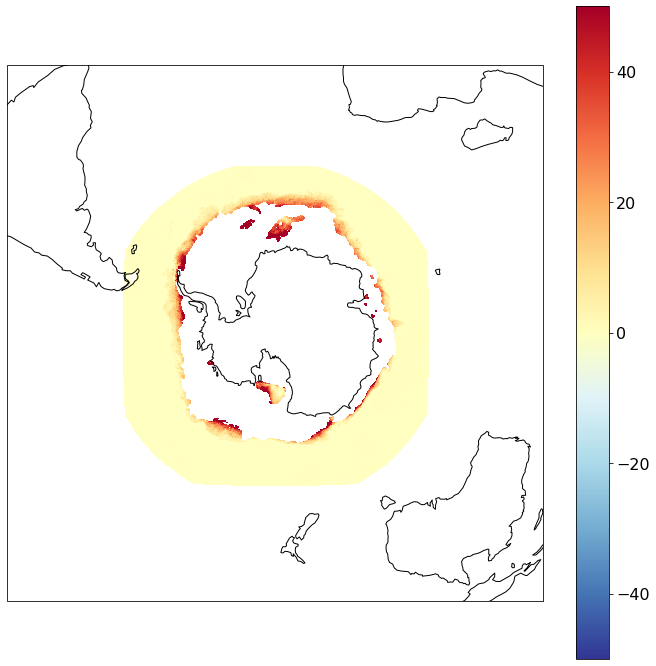

In [261]:
plt.figure(figsize=(12,12))
cmap_rf = plt.get_cmap('RdYlBu_r')
#cmap2 = cmap.set_over('black')
ax=plt.axes(projection=ccrs.LambertAzimuthalEqualArea(central_latitude=-90))
plt.pcolormesh(alteredstate_SH['longitude'], alteredstate_SH['latitude'], \
                thisCrRF.where(alteredstate_SH.isel(time=i)==statechange['WATER']), transform=ccrs.PlateCarree(),
               cmap = cmap_rf, vmin=-50, vmax=50)
ax.coastlines()

#cbticks = np.arange(1,len(statechange)+1)
#cblabels = [list(statechange.keys())[list(statechange.values()).index(x)] for x in np.arange(1,len(statechange)+1)]

cb = plt.colorbar()
#cb.set_ticks(cbticks)
#cb.set_ticklabels(cblabels)
ax.set_extent((-180,180,-25,-90), crs=ccrs.PlateCarree())
plt.show()

As a note, it is clear that the OSI450 SH SIC produces a larger sea ice extent than the G02202 used here - resulting in some of the delta-CrRF being assigned to WATER while the signal obviously originates from water-sea ice changes.

In [74]:
#Try customizing the data to use seaborn bar plotting
periods = len(CLARA_monthly_forcings_CACK_3yrmean_domain_SH.index) * 4 #NH, SH, SEAICE, TERRESTRIAL
sb_3yr_forcings = pd.DataFrame(columns = ['Time','Hemisphere', 'Domain','Forcing'], index=np.arange(0,periods))
#print(sb_3yr_forcings)
i=-1

for dt in CLARA_monthly_forcings_CACK_3yrmean_domain_SH.index:
    i+=1
    #sb_3yr_forcings.at[0, dt, 'SH', 'TERRESTRIAL'] = CLARA_monthly_forcings_CACK_3yrmean_domain_SH['SEAICE'][dt]
    #sb_3yr_forcings.at[0, dt, 'SH', 'SEAICE'] = CLARA_monthly_forcings_CACK_3yrmean_domain_SH['SNOW'][dt] + \
    #                          CLARA_monthly_forcings_CACK_3yrmean_domain_SH['LAND'][dt]
    sb_3yr_forcings.iat[i,0] = dt.strftime('%Y')
    sb_3yr_forcings.iat[i,1] = 'Antarctic'
    sb_3yr_forcings.iat[i,2] = 'TERRESTRIAL'
    sb_3yr_forcings.iat[i,3] = CLARA_monthly_forcings_CACK_3yrmean_domain_SH['SNOW'][dt] + \
                              CLARA_monthly_forcings_CACK_3yrmean_domain_SH['LAND'][dt]
    i+=1
    sb_3yr_forcings.iat[i,0] = dt.strftime('%Y')
    sb_3yr_forcings.iat[i,1] = 'Antarctic'
    sb_3yr_forcings.iat[i,2] = 'OCEANIC'
    sb_3yr_forcings.iat[i,3] = CLARA_monthly_forcings_CACK_3yrmean_domain_SH['SEAICE'][dt] + \
                                CLARA_monthly_forcings_CACK_3yrmean_domain_SH['WATER'][dt]

    i+=1
    sb_3yr_forcings.iat[i,0] = dt.strftime('%Y')
    sb_3yr_forcings.iat[i,1] = 'Arctic'
    sb_3yr_forcings.iat[i,2] = 'TERRESTRIAL'
    sb_3yr_forcings.iat[i,3] = CLARA_monthly_forcings_CACK_3yrmean_domain_NH['SNOW'][dt] + \
                              CLARA_monthly_forcings_CACK_3yrmean_domain_NH['LAND'][dt]
    i+=1
    sb_3yr_forcings.iat[i,0] = dt.strftime('%Y')
    sb_3yr_forcings.iat[i,1] = 'Arctic'
    sb_3yr_forcings.iat[i,2] = 'OCEANIC'
    sb_3yr_forcings.iat[i,3] = CLARA_monthly_forcings_CACK_3yrmean_domain_NH['SEAICE'][dt] + \
                                CLARA_monthly_forcings_CACK_3yrmean_domain_NH['WATER'][dt]
print(sb_3yr_forcings)

#print(CLARA_monthly_forcings_CACK_3yrmean_domain_SH)

    Time Hemisphere       Domain     Forcing
0   1992  Antarctic  TERRESTRIAL  0.00999987
1   1992  Antarctic      OCEANIC -0.00989947
2   1992     Arctic  TERRESTRIAL  0.00241347
3   1992     Arctic      OCEANIC -0.00150694
4   1995  Antarctic  TERRESTRIAL  -0.0026371
5   1995  Antarctic      OCEANIC -0.00911677
6   1995     Arctic  TERRESTRIAL   0.0298029
7   1995     Arctic      OCEANIC   0.0256044
8   1998  Antarctic  TERRESTRIAL  0.00680795
9   1998  Antarctic      OCEANIC -0.00302469
10  1998     Arctic  TERRESTRIAL    0.043996
11  1998     Arctic      OCEANIC   0.0243902
12  2001  Antarctic  TERRESTRIAL   -0.011137
13  2001  Antarctic      OCEANIC  -0.0586864
14  2001     Arctic  TERRESTRIAL   0.0405159
15  2001     Arctic      OCEANIC   0.0329724
16  2004  Antarctic  TERRESTRIAL -0.00820923
17  2004  Antarctic      OCEANIC  -0.0337193
18  2004     Arctic  TERRESTRIAL   0.0331274
19  2004     Arctic      OCEANIC   0.0597067
20  2007  Antarctic  TERRESTRIAL  -0.0147073
21  2007  

<Figure size 432x288 with 0 Axes>

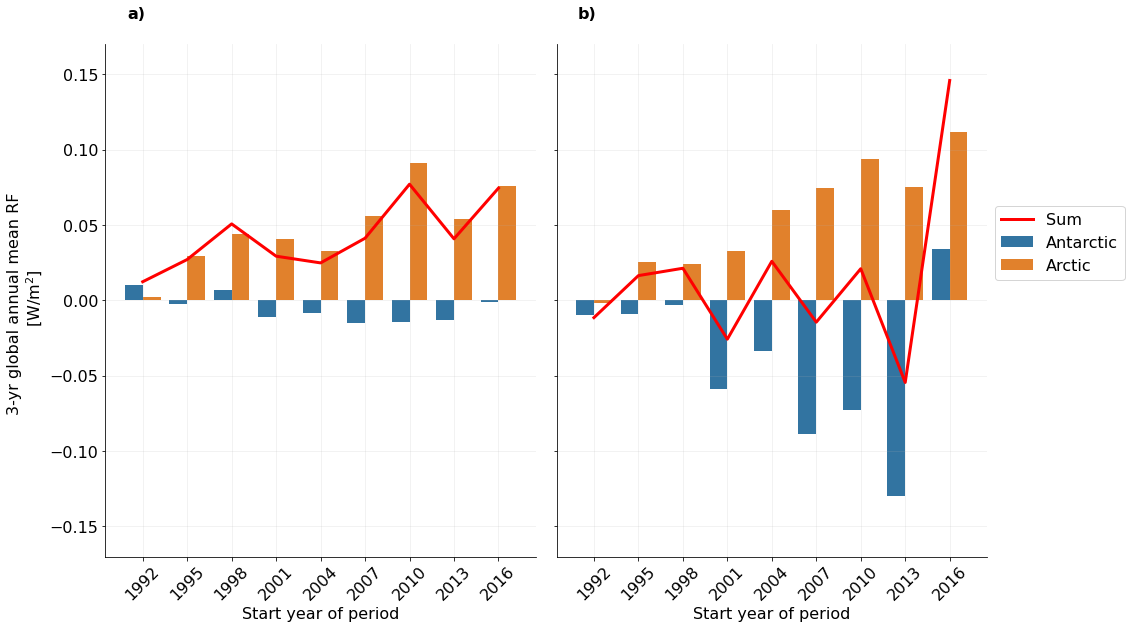

In [367]:
import seaborn as sns
ocean_sum = CLARA_monthly_forcings_CACK_3yrmean_domain_NH['SEAICE'].values + \
    CLARA_monthly_forcings_CACK_3yrmean_domain_SH['SEAICE'].values + \
    CLARA_monthly_forcings_CACK_3yrmean_domain_NH['WATER'].values + \
    CLARA_monthly_forcings_CACK_3yrmean_domain_SH['WATER'].values

terr_sum = CLARA_monthly_forcings_CACK_3yrmean_domain_NH['SNOW'].values+\
    CLARA_monthly_forcings_CACK_3yrmean_domain_SH['SNOW'].values+\
    CLARA_monthly_forcings_CACK_3yrmean_domain_NH['LAND'].values+\
    CLARA_monthly_forcings_CACK_3yrmean_domain_SH['LAND'].values

#import matplotlib.pyplot as plt
fig = plt.figure()
b1 = sns.catplot(x = 'Time', y='Forcing', hue = 'Hemisphere', col='Domain',data=sb_3yr_forcings, kind='bar',\
                legend_out=False)
b1.set_xticklabels(rotation=45)

axes = b1.fig.axes
#ax=plt.gca()
axes[0].plot(terr_sum, linewidth=3, color='r', label='Sum')
axes[1].plot(ocean_sum, linewidth=3, color='r', label='Sum')

axes[0].get_legend().remove()
axes[1].legend(loc=0, bbox_to_anchor=(1, 0.7))
axes[0].set_ylabel('3-yr global annual mean RF \n [W/m$^2$]')
axes[0].set_xlabel('Start year of period')
axes[1].set_xlabel('Start year of period')
axes[0].set_ylim(-0.17, 0.17)
axes[1].set_ylim(-0.17, 0.17)
b1.fig.set_figwidth(16)
b1.fig.set_figheight(9)
axes[0].grid(alpha=0.2)
axes[1].grid(alpha=0.2)
axes[0].set_title('')
axes[1].set_title('')
axes[0].text(0.05, 1.05, 'a)', fontweight='bold', transform=axes[0].transAxes)
axes[1].text(0.05, 1.05, 'b)', fontweight='bold', transform=axes[1].transAxes)
plt.tight_layout()
plt.savefig(figure_dir + 'Figure2.png', dpi=300)
plt.savefig(figure_dir + 'Figure2.pdf', dpi=300)
plt.show(b1)

<Figure size 432x288 with 0 Axes>

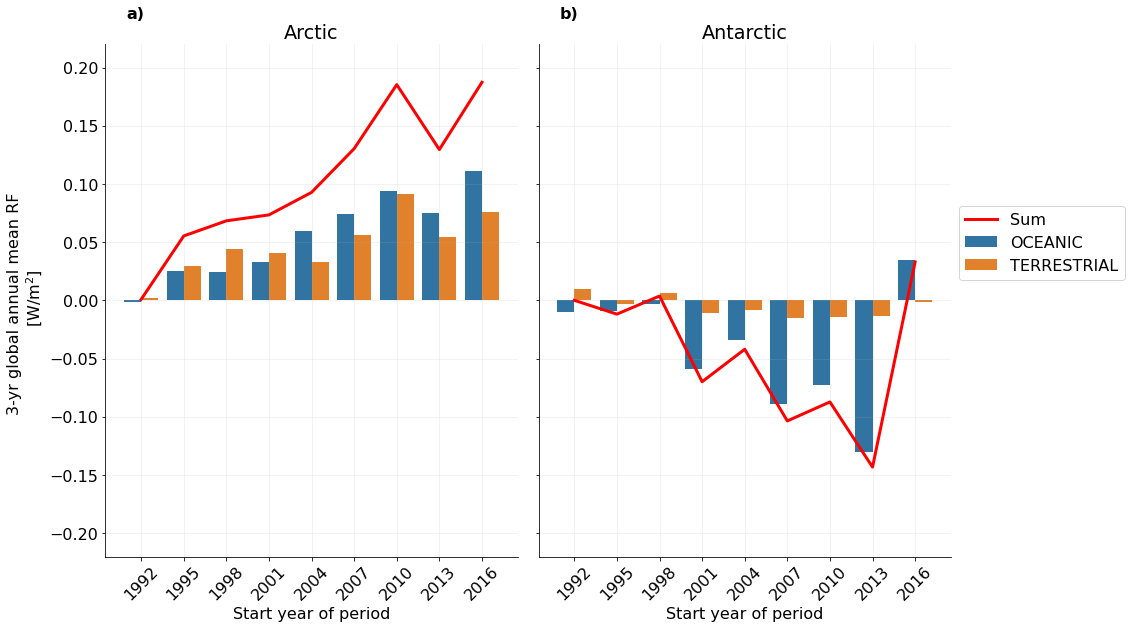

In [81]:
#revised version, domain/hemisphere reversed
import seaborn as sns
ocean_sum = CLARA_monthly_forcings_CACK_3yrmean_domain_NH['SEAICE'].values + \
    CLARA_monthly_forcings_CACK_3yrmean_domain_SH['SEAICE'].values + \
    CLARA_monthly_forcings_CACK_3yrmean_domain_NH['WATER'].values + \
    CLARA_monthly_forcings_CACK_3yrmean_domain_SH['WATER'].values

terr_sum = CLARA_monthly_forcings_CACK_3yrmean_domain_NH['SNOW'].values+\
    CLARA_monthly_forcings_CACK_3yrmean_domain_SH['SNOW'].values+\
    CLARA_monthly_forcings_CACK_3yrmean_domain_NH['LAND'].values+\
    CLARA_monthly_forcings_CACK_3yrmean_domain_SH['LAND'].values

NH_sum = CLARA_monthly_forcings_CACK_3yrmean_domain_NH['SEAICE'].values + \
    CLARA_monthly_forcings_CACK_3yrmean_domain_NH['SNOW'].values + \
    CLARA_monthly_forcings_CACK_3yrmean_domain_NH['WATER'].values + \
    CLARA_monthly_forcings_CACK_3yrmean_domain_NH['LAND'].values

SH_sum = CLARA_monthly_forcings_CACK_3yrmean_domain_SH['SEAICE'].values + \
    CLARA_monthly_forcings_CACK_3yrmean_domain_SH['SNOW'].values + \
    CLARA_monthly_forcings_CACK_3yrmean_domain_SH['WATER'].values + \
    CLARA_monthly_forcings_CACK_3yrmean_domain_SH['LAND'].values

#import matplotlib.pyplot as plt
fig = plt.figure()
b1 = sns.catplot(x = 'Time', y='Forcing', hue = 'Domain', col='Hemisphere',data=sb_3yr_forcings, kind='bar',\
                legend_out=False, col_order=['Arctic', 'Antarctic'], hue_order=['OCEANIC', 'TERRESTRIAL'])
b1.set_xticklabels(rotation=45)

axes = b1.fig.axes
#ax=plt.gca()
axes[0].plot(NH_sum, linewidth=3, color='r', label='Sum')
axes[1].plot(SH_sum, linewidth=3, color='r', label='Sum')

axes[0].get_legend().remove()
axes[1].legend(loc=0, bbox_to_anchor=(1, 0.7))
axes[0].set_ylabel('3-yr global annual mean RF \n [W/m$^2$]')
axes[0].set_xlabel('Start year of period')
axes[1].set_xlabel('Start year of period')
axes[0].set_ylim(-0.22, 0.22)
axes[1].set_ylim(-0.22, 0.22)
b1.fig.set_figwidth(16)
b1.fig.set_figheight(9)
axes[0].grid(alpha=0.2)
axes[1].grid(alpha=0.2)
axes[0].set_title('Arctic')
axes[1].set_title('Antarctic')
axes[0].text(0.05, 1.05, 'a)', fontweight='bold', transform=axes[0].transAxes)
axes[1].text(0.05, 1.05, 'b)', fontweight='bold', transform=axes[1].transAxes)
plt.tight_layout()
plt.savefig(figure_dir + 'Figure2_reversed.png', dpi=300)
plt.savefig(figure_dir + 'Figure2_reversed.pdf', dpi=300)
plt.show(b1)

In [189]:
Loss_period = radiative_forcing_CLARAWSA_CACK_SH.sel(time=slice('2016','2018'), perturbation=0).mean('time')
Intact_period = radiative_forcing_CLARAWSA_CACK_SH.sel(time=slice('2013','2015'), perturbation=0).mean('time')

C:\Users\riihelaa\AppData\Local\Continuum\anaconda3\envs\scientia\lib\site-packages\xarray\core\nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


C:\Users\riihelaa\AppData\Local\Continuum\anaconda3\envs\scientia\lib\site-packages\ipykernel_launcher.py:47: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
C:\Users\riihelaa\AppData\Local\Continuum\anaconda3\envs\scientia\lib\site-packages\ipykernel_launcher.py:47: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


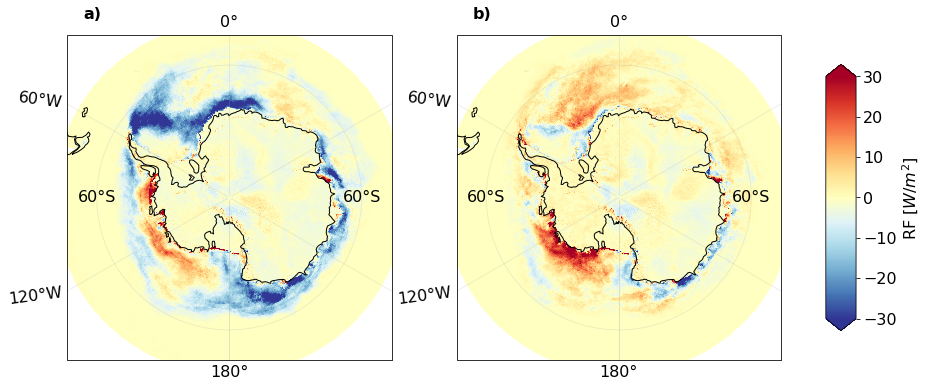

In [218]:
#fig = plt.figure(figsize=(18,11))
fig, [ax1, ax2] = plt.subplots(1,2,\
                               figsize=(16,7),subplot_kw=dict(projection = ccrs.LambertAzimuthalEqualArea(central_latitude=-90))) 
cmap_change = plt.get_cmap('RdYlBu_r')
#ax1=plt.subplot(121,projection=ccrs.LambertAzimuthalEqualArea(central_latitude=-90))
p1=ax1.pcolormesh(radiative_forcing_CLARAWSA_CACK_SH['longitude'], radiative_forcing_CLARAWSA_CACK_SH['latitude'], \
                Intact_period.where(Intact_period['latitude']<SH_latlimit), \
               transform=ccrs.PlateCarree(), cmap=cmap_change, vmin=-30, vmax=30)
ax1.coastlines()
gl1 = ax1.gridlines(draw_labels=True, alpha=0.25, y_inline=True)
gl1.ylocator = mticker.FixedLocator([-60])
gl1.right_labels=False
#cb = plt.colorbar(p1,ax=ax1)
ax1.set_extent((-180,180,-53,-90), crs=ccrs.PlateCarree())



#ax2=plt.subplot(122,projection=ccrs.LambertAzimuthalEqualArea(central_latitude=-90))
p2=ax2.pcolormesh(radiative_forcing_CLARAWSA_CACK_SH['longitude'], radiative_forcing_CLARAWSA_CACK_SH['latitude'], \
                Loss_period.where(Loss_period['latitude']<SH_latlimit), \
               transform=ccrs.PlateCarree(), cmap=cmap_change, vmin=-30, vmax=30)
ax2.coastlines()
gl2 = ax2.gridlines(draw_labels=True, alpha=0.25, y_inline=True)
gl2.ylocator = mticker.FixedLocator([-60])
gl2.right_labels=False

cb = fig.colorbar(p2, ax=[ax1, ax2], shrink=0.7, extend='both', aspect=8)
cb.set_label('RF [$W/m^2$]')


#cbar_ax = fig.add_axes([0.92, 0.2, 0.03, 0.6])
#cb = plt.colorbar(p2,cax=cbar_ax)
#cb.set_label('RF [$W/m^2$]')

#divider = make_axes_locatable(ax2)
#cax = divider.append_axes("right", "5%", pad="3%")
#cb = plt.colorbar(p2, cax=cax)
#cb.set_label('RF [$W/m^2$]')


ax2.set_extent((-180,180,-53,-90), crs=ccrs.PlateCarree())
#ax1.set_title('3-yr mean RF vs. baseline,\n 2013-2015')
#ax2.set_title('3-yr mean RF vs. baseline,\n 2016-2018')
ax1.text(0.05, 1.05, 'a)', fontweight='bold', transform=ax1.transAxes)
ax2.text(0.05, 1.05, 'b)', fontweight='bold', transform=ax2.transAxes)
#fig.canvas.draw()
plt.tight_layout()

plt.savefig(figure_dir + 'Figure3AG.png', dpi=300)
#plt.savefig(figure_dir + 'Figure3AG.pdf', dpi=300)
plt.show()

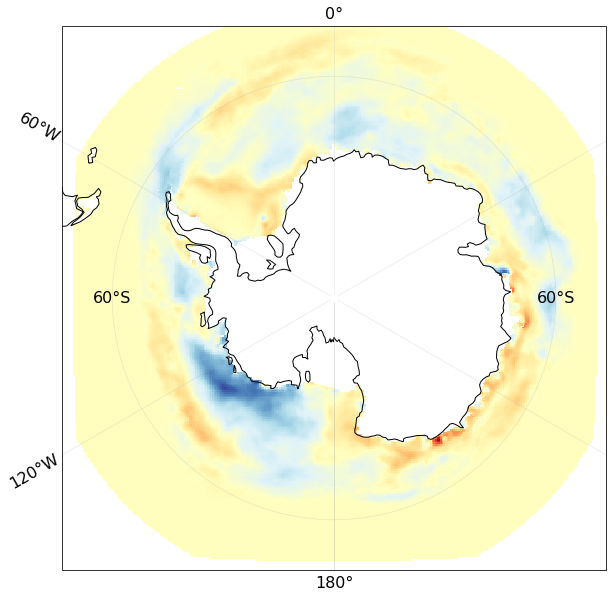

In [271]:
SICdiff=(Antarctic_SIC.sel(time=slice('2016','2018')).mean(('time'))-Antarctic_SIC.sel(time=slice('1982','1991')).mean('time'))
fig = plt.figure(figsize=(10,10))
ax1 = plt.axes(projection = ccrs.LambertAzimuthalEqualArea(central_latitude=-90))
cmap_change = plt.get_cmap('RdYlBu_r')
#ax1=plt.subplot(121,projection=ccrs.LambertAzimuthalEqualArea(central_latitude=-90))
p1=ax1.pcolormesh(radiative_forcing_CLARAWSA_CACK_SH['longitude'], radiative_forcing_CLARAWSA_CACK_SH['latitude'], \
                SICdiff, \
               transform=ccrs.PlateCarree(), cmap=cmap_change, vmin=-.30, vmax=.30)
ax1.coastlines()
gl1 = ax1.gridlines(draw_labels=True, alpha=0.25, y_inline=True)
gl1.ylocator = mticker.FixedLocator([-60])
gl1.right_labels=False
#cb = plt.colorbar(p1,ax=ax1)
ax1.set_extent((-180,180,-53,-90), crs=ccrs.PlateCarree())
plt.show()

In [266]:
#calculate CACK statistics

CACK_stats_NH = xr.Dataset()
CACK_stats_NH['CACK_mean'] = CACK_ALB_KERNEL_EASE2_NH_xr.where(CACK_ALB_KERNEL_EASE2_NH_xr.latitude>NH_latlimit).mean(('lat', 'lon'))
CACK_stats_NH['CACK_median'] = CACK_ALB_KERNEL_EASE2_NH_xr.where(CACK_ALB_KERNEL_EASE2_NH_xr.latitude>NH_latlimit).median(('lat', 'lon'))
CACK_stats_NH['CACK_std'] = CACK_ALB_KERNEL_EASE2_NH_xr.where(CACK_ALB_KERNEL_EASE2_NH_xr.latitude>NH_latlimit).std(('lat', 'lon'))

CACK_stats_SH = xr.Dataset()
CACK_stats_SH['CACK_mean'] = CACK_ALB_KERNEL_EASE2_SH_xr.where(CACK_ALB_KERNEL_EASE2_NH_xr.latitude<SH_latlimit).mean(('lat', 'lon'))
CACK_stats_SH['CACK_median'] = CACK_ALB_KERNEL_EASE2_SH_xr.where(CACK_ALB_KERNEL_EASE2_NH_xr.latitude<SH_latlimit).median(('lat', 'lon'))
CACK_stats_SH['CACK_std'] = CACK_ALB_KERNEL_EASE2_SH_xr.where(CACK_ALB_KERNEL_EASE2_NH_xr.latitude<SH_latlimit).std(('lat', 'lon'))


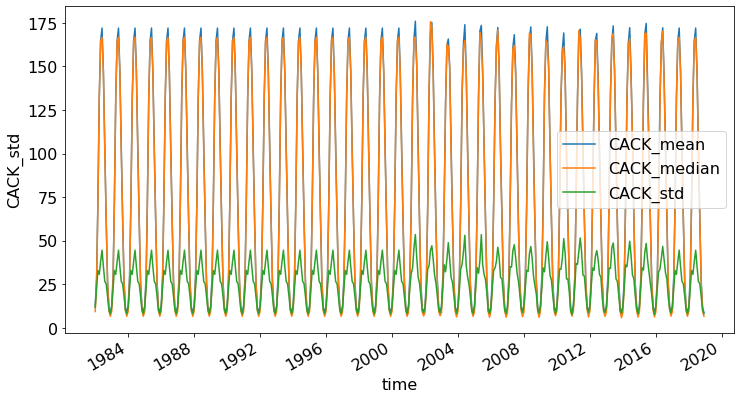

In [267]:
plt.figure(figsize=(12,6))
for k in list(CACK_stats_NH.keys()):
    CACK_stats_NH[k].plot(label=k)
    plt.legend()
plt.savefig(figure_dir + 'CACK_NH_statistics_latlimited.png')

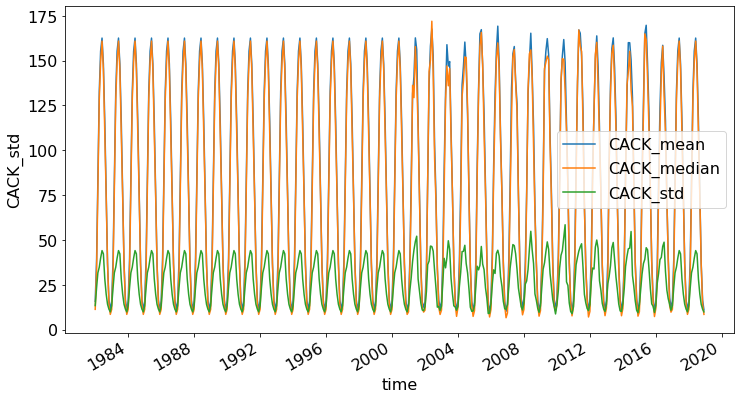

In [268]:
plt.figure(figsize=(12,6))
for k in list(CACK_stats_SH.keys()):
    CACK_stats_SH[k].plot(label=k)
    plt.legend()
plt.savefig(figure_dir + 'CACK_SH_statistics_latlimited.png')

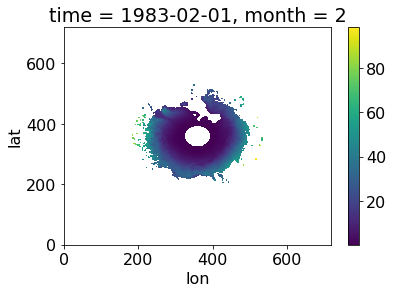

In [271]:
missingsignal_NH[13,:,:].plot()

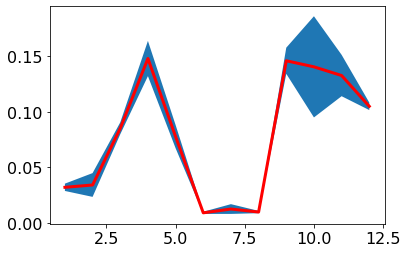

In [276]:
missing_RF_CACK_resolved_NH = ((missingsignal_NH * -1 * albedo_lost_signal_NH).sum(('lat','lon'))*area_normalization)

missing_RF_CACK_MM_NH = missing_RF_CACK_resolved_NH.groupby(missing_RF_CACK_resolved_NH.time.dt.month).mean()
missing_RF_CACK_MM_NH_std = missing_RF_CACK_resolved_NH.groupby(missing_RF_CACK_resolved_NH.time.dt.month).std()
plt.fill_between(missing_RF_CACK_MM_NH.month, \
                 missing_RF_CACK_MM_NH+missing_RF_CACK_MM_NH_std, \
                 missing_RF_CACK_MM_NH-missing_RF_CACK_MM_NH_std)
plt.plot(missing_RF_CACK_MM_NH.month, missing_RF_CACK_MM_NH, 'r', linewidth=3)

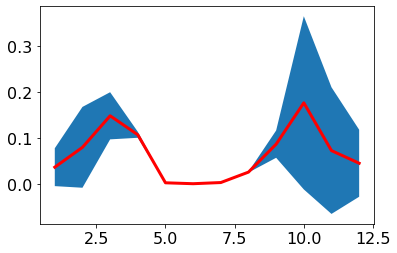

In [277]:
missing_RF_CACK_resolved_SH = ((missingsignal_SH * -1 * albedo_lost_signal_SH).sum(('lat','lon'))*area_normalization)

missing_RF_CACK_MM_SH = missing_RF_CACK_resolved_SH.groupby(missing_RF_CACK_resolved_SH.time.dt.month).mean()
missing_RF_CACK_MM_SH_std = missing_RF_CACK_resolved_SH.groupby(missing_RF_CACK_resolved_SH.time.dt.month).std()
plt.fill_between(missing_RF_CACK_MM_SH.month, \
                 missing_RF_CACK_MM_SH+missing_RF_CACK_MM_SH_std, \
                 missing_RF_CACK_MM_SH-missing_RF_CACK_MM_SH_std)
plt.plot(missing_RF_CACK_MM_SH.month, missing_RF_CACK_MM_SH, 'r', linewidth=3)

In [278]:
studyarea_NH=xr.where(CACK_ALB_KERNEL_EASE2_NH_xr[0,:,:].latitude>NH_latlimit,1,np.nan).count()
studyarea_SH=xr.where(CACK_ALB_KERNEL_EASE2_SH_xr[0,:,:].latitude<SH_latlimit,1,np.nan).count()

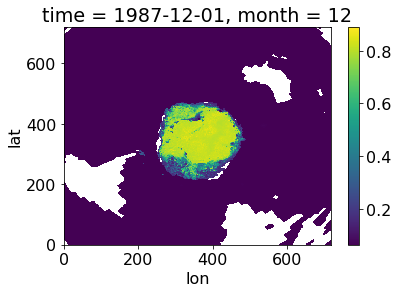

In [279]:
defWSA_EASE2_all_SH[11*6+5,:,:].plot()

In [82]:
# Table 1 content. RF for select years, plus CO2_RF from standard equation 
#(updates in Etminan et al., 2016 not significant for a short timeline) for reference. 
# Annual mean CO2 from NOAA ESRL.


CO2_global = pd.read_table(prod_data_dir + 'co2_annmean_gl.txt', header=56, delim_whitespace=True, index_col='year')
#print(CO2_global)
CO2_global_baseline = CO2_global['mean'].loc[1982:1991].mean()
CO2_preindustrial_baseline = 278
#print(CO2_global_baseline)

a1 = -2.4e-7
b1 = 7.2e-4
c1 = -2.1e-4

CO2diff = CO2_global['mean']-CO2_global_baseline

CO2_RF = 5.35 * np.log(CO2_global['mean']/CO2_global_baseline)
CO2_RF_preind = 5.35 * np.log(CO2_global['mean']/CO2_preindustrial_baseline)



Tab1_df = pd.DataFrame(columns=['1994','2004','2014', '2016','2018'])

for y in Tab1_df.columns:
    print(y)
    Tab1_df.loc['Arctic',y] = np.round((combined_NH).sel(time=y).values[0],3)
    Tab1_df.loc['Antarctic',y] = np.round((combined_SH).sel(time=y).values[0],3)
    Tab1_df.loc['Arctic+Antarctic',y] = np.round((combined_NH+combined_SH).sel(time=y).values[0],3)
    Tab1_df.loc['RF-CO2 vs 1982-1991',y] = np.round(CO2_RF[np.int(y)],3)
    
    
Tab1_df

1994
2004
2014
2016
2018


1994   2004   2014   2016   2018
Arctic               0.061  0.049  0.165  0.292  0.165
Antarctic           -0.019 -0.069 -0.171  0.045  0.036
Arctic+Antarctic     0.041 -0.019 -0.006  0.336  0.202
RF-CO2 vs 1982-1991  0.152  0.423  0.704  0.781  0.841

In [83]:
Tab1_df.loc['Arctic+Antarctic','2016']/Tab1_df.loc['RF-CO2 vs 1982-1991','2016']

0.43021766965428937

In [84]:
Tab1_df.loc['Arctic+Antarctic','2018']/Tab1_df.loc['RF-CO2 vs 1982-1991','2018']

0.24019024970273486

In [85]:
CO2_global_baseline

348.13800000000003

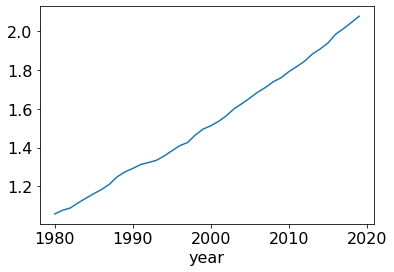

In [86]:
CO2_RF_preind.plot()

In [87]:
CO2_global['mean'].loc['2016':'2018'].mean()

405.08

In [88]:
#CO2 forcing from 2016-2018 mean against 1982-1991 baseline CO2 level
5.35 * np.log(CO2_global['mean'].loc['2016':'2018'].mean()/CO2_global_baseline)

0.8104480968065974

In [275]:
#so that the 2016-2018 mean RF constitutes X% of CO2 against the same baseline...
print((combined_NH+combined_SH).sel(time=slice('2016','2018')).mean()/(5.35 * np.log(CO2_global['mean'].loc['2016':'2018'].mean()/CO2_global_baseline)))

<xarray.DataArray ()>
array(0.32486813)


In [418]:
snowicecover_NH = xr.open_dataarray(prod_data_dir + 'NSIDC0046_snowicecover_MM_at_EASE2NH_1982_2018.nc')
snowicecover_NH = snowicecover_NH.transpose('time','lat','lon')
snowicecover_NH = xr.where(((snowicecover_NH>5) & (WSA_EASE2_all_NH>0.12)), 3, snowicecover_NH)


C:\Users\riihelaa\AppData\Local\Continuum\anaconda3\envs\scientia\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: This DataArray contains multi-dimensional coordinates. In the future, these coordinates will be transposed as well unless you specify transpose_coords=False.
  


In [480]:
snowicecover_NH_BL_min = snowicecover_NH.sel(time=slice('1982','1991')).groupby(snowicecover_NH.sel(time=slice('1982','1991')).time.dt.month).max()

C:\Users\riihelaa\AppData\Local\Continuum\anaconda3\envs\scientia\lib\site-packages\xarray\core\common.py:664: FutureWarning: This DataArray contains multi-dimensional coordinates. In the future, the dimension order of these coordinates will be restored as well unless you specify restore_coord_dims=False.
  self, group, squeeze=squeeze, restore_coord_dims=restore_coord_dims


In [481]:
nosnowmask_NH = snowicecover_NH.copy().chunk((1,720,720)) * np.nan


for thisdt in tqdm(snowicecover_NH.time):
    this_snowcover = snowicecover_NH.sel(time=thisdt)
    this_baseline_snowcover = snowicecover_NH_BL_min.sel(month=thisdt.dt.month)
    #nosnowmask = this_snowcover.copy() * np.nan
    nosnowmask_this = xr.where((this_snowcover==0) & (this_baseline_snowcover==0),1,np.nan )
    
    nosnowmask_NH = xr.where(nosnowmask_NH.time==thisdt, nosnowmask_this, nosnowmask_NH)

In [482]:
nosnowmask_NH = nosnowmask_NH.compute()

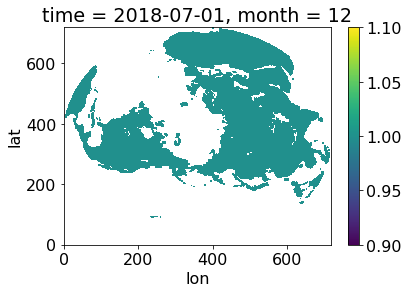

In [484]:
nosnowmask_NH[-6,:,:].plot()

In [485]:
## RF from non-cryospheric land over Arctic
RF_land_CC_annualmean = radiative_forcing_CLARAWSA_CC_NH.sel(perturbation=0).fillna(fillval_RF).where(nosnowmask_NH==1).where(radiative_forcing_CLARAWSA_CC_NH.latitude>NH_latlimit).sum(('lat', 'lon')).resample(time='AS').mean('time') * area_normalization
RF_land_CACK_annualmean = radiative_forcing_CLARAWSA_CACK_NH.sel(perturbation=0).fillna(fillval_RF).where(nosnowmask_NH==1).where(radiative_forcing_CLARAWSA_CC_NH.latitude>NH_latlimit).sum(('lat', 'lon')).resample(time='AS').mean('time') * area_normalization

RF_land_CC_annualmean = RF_land_CC_annualmean.compute()
RF_land_CACK_annualmean = RF_land_CACK_annualmean.compute()

In [486]:
RF_land_CC_annualmean

<xarray.DataArray (time: 37)>
array([-0.00800642, -0.02705345, -0.00232847, -0.00369446, -0.00636316,
        0.00123923,  0.02967029,  0.00949229,  0.00473714,  0.00230701,
       -0.03563683,  0.00430349,  0.03784152,  0.02119702,  0.0213484 ,
        0.04619161,  0.03714087,  0.02438842,  0.02993117,  0.0315248 ,
        0.01364741,  0.00763666,  0.01681203,  0.02286014,  0.01952094,
        0.01574134,  0.01492922,  0.01858642,  0.02934073,  0.02151469,
       -0.00161044, -0.00198078,  0.00936939,  0.02560312,  0.04267668,
        0.0386501 ,  0.03253023])
Coordinates:
  * time     (time) datetime64[ns] 1982-01-01 1983-01-01 ... 2018-01-01

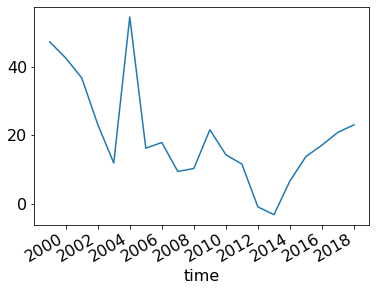

In [492]:
((RF_land_CC_annualmean/annual_mean_CACK_NH.sel(perturbation=0))*100.).sel(time=slice('1999','2018')).plot()

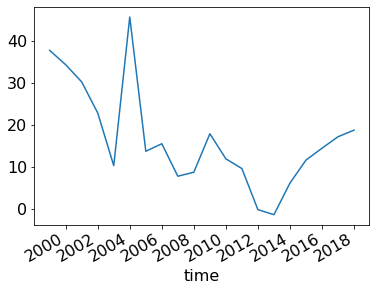

In [491]:
((RF_land_CACK_annualmean/annual_mean_CACK_NH.sel(perturbation=0))*100.).sel(time=slice('1999','2018')).plot()

In [516]:
annual_mean_CACK_NH.sel(perturbation=0).sel(time='2004')

<xarray.DataArray (time: 1)>
array([0.030808])
Coordinates:
  * time     (time) datetime64[ns] 2004-01-01

In [604]:
## delta-WSA vs. SIE/SIC
baseline_82_91_NH = WSA_EASE2_all_NH.sel(time=slice('1982','1991'))
baseline_82_91_NH = baseline_82_91_NH.groupby(baseline_82_91_NH.time.dt.month).mean('time').compute()

baseline_82_91_SH = WSA_EASE2_all_SH.sel(time=slice('1982','1991'))
baseline_82_91_SH = baseline_82_91_SH.groupby(baseline_82_91_SH.time.dt.month).mean('time').compute()


C:\Users\riihelaa\AppData\Local\Continuum\anaconda3\envs\scientia\lib\site-packages\xarray\core\nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\riihelaa\AppData\Local\Continuum\anaconda3\envs\scientia\lib\site-packages\xarray\core\common.py:664: FutureWarning: This DataArray contains multi-dimensional coordinates. In the future, the dimension order of these coordinates will be restored as well unless you specify restore_coord_dims=False.
  self, group, squeeze=squeeze, restore_coord_dims=restore_coord_dims


In [630]:
albdiff_NH = WSA_EASE2_all_NH.copy(deep=True) * np.nan
albdiff_SH = WSA_EASE2_all_SH.copy(deep=True) * np.nan

for tdt in tqdm(WSA_EASE2_all_NH.time):
    thisWSA = WSA_EASE2_all_NH.where(WSA_EASE2_all_NH.time == tdt, drop=True)
    diff = thisWSA - baseline_82_91_NH.sel(month=tdt.dt.month)
    albdiff_NH.loc[dict(time=tdt)] =  np.squeeze(diff.values)
    
for tdt in tqdm(WSA_EASE2_all_SH.time):
    thisWSA = WSA_EASE2_all_SH.where(WSA_EASE2_all_SH.time == tdt, drop=True)
    diff = thisWSA - baseline_82_91_SH.sel(month=tdt.dt.month)
    albdiff_SH.loc[dict(time=tdt)] =  np.squeeze(diff.values)

In [631]:
Alb_diff_mean_NH = []
for tdt in tqdm(albdiff_NH.time):
    #print(tdt.values)
    try:
        thisSIC = Arctic_SIC.sel(time=tdt)
    except KeyError:
        #meanSI_anoms_NH.append(xr.DataArray(np.ones(1)*np.nan, dims=['time'], coords=[('time',[tdt.time.values])]))
        Alb_diff_mean_NH.append(xr.DataArray(np.ones(1)*np.nan, dims=['time'], coords=[('time',[tdt.time.values])]))
        continue
    SI_mask = xr.where(~xr.ufuncs.isnan(thisSIC),1,np.nan)

    thisAlb = albdiff_NH.sel(time=tdt).where(radiative_forcing_CLARAWSA_CACK_NH.latitude>NH_latlimit).fillna(0.0) * SI_mask
    Alb_diff_mean_NH.append(thisAlb.mean(('lat', 'lon')).drop('month'))

Alb_diff_mean_SH = []
for tdt in tqdm(albdiff_SH.time):
    #print(tdt.values)
    try:
        thisSIC = Antarctic_SIC.sel(time=tdt)
    except KeyError:
        #meanSI_anoms_NH.append(xr.DataArray(np.ones(1)*np.nan, dims=['time'], coords=[('time',[tdt.time.values])]))
        Alb_diff_mean_SH.append(xr.DataArray(np.ones(1)*np.nan, dims=['time'], coords=[('time',[tdt.time.values])]))
        continue
    SI_mask = xr.where(~xr.ufuncs.isnan(thisSIC),1,np.nan)

    thisAlb = albdiff_SH.sel(time=tdt).where(radiative_forcing_CLARAWSA_CACK_SH.latitude<SH_latlimit).fillna(0.0) * SI_mask
    Alb_diff_mean_SH.append(thisAlb.mean(('lat', 'lon')).drop('month'))

C:\Users\riihelaa\AppData\Local\Continuum\anaconda3\envs\scientia\lib\site-packages\xarray\core\nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


In [632]:
Alb_diff_mean_NH_annual = xr.concat(Alb_diff_mean_NH, dim='time')\
    .reindex(time=pd.date_range('01-01-1982', '31-12-'+str(stopyear), freq='MS')).resample(time='AS').mean()
Alb_diff_mean_SH_annual = xr.concat(Alb_diff_mean_SH, dim='time')\
    .reindex(time=pd.date_range('01-01-1982', '31-12-'+str(stopyear), freq='MS')).resample(time='AS').mean()

C:\Users\riihelaa\AppData\Local\Continuum\anaconda3\envs\scientia\lib\site-packages\xarray\core\nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


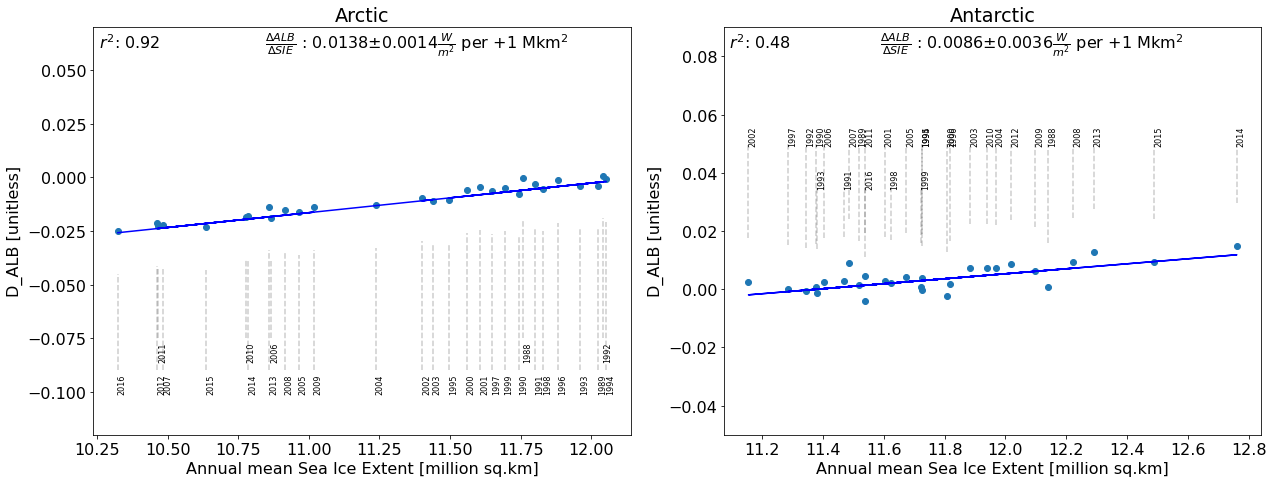

In [674]:
Alb_diff_mean_NH_annual_crop = Alb_diff_mean_NH_annual.sel(time=slice('1988','2016'))
Alb_diff_mean_SH_annual_crop = Alb_diff_mean_SH_annual.sel(time=slice('1988','2016'))


SH_extent_annual = SI_areas_SH.mean(axis=1).loc['1988':'2016']
NH_extent_annual = SI_areas_NH.mean(axis=1).loc['1988':'2016']

#SH_extent_annual = SH_extent_annual.drop([1994,2000])
#meanSI_RFs_CC_SH_annual_crop = meanSI_RFs_CC_SH_annual.drop_sel(time=[pd.to_datetime('1994-01-01'), pd.to_datetime('2000-01-01')])
#meanSI_RFs_CACK_SH_annual_crop = meanSI_RFs_CACK_SH_annual.drop_sel(time=[pd.to_datetime('1994-01-01'), pd.to_datetime('2000-01-01')])



f=plt.figure(figsize=(18,7))

###SH###
plt.subplot(122)

plt.scatter(SH_extent_annual, Alb_diff_mean_SH_annual_crop)
downpressed = [1993,1999,1991, 1998, 2016]
for i, txt in enumerate(Alb_diff_mean_SH_annual_crop.time):
    if txt.dt.year in downpressed:
        shift = -0.015
    else:
        shift = 0    
    plt.annotate(pd.to_datetime(txt.values).strftime('%Y'), \
                 (SH_extent_annual.values[i], \
                  0.05+shift), fontsize=8, rotation=90)
    plt.vlines(SH_extent_annual.values[i], Alb_diff_mean_SH_annual_crop[i].values+0.015, 0.05+shift, linestyle='--', alpha=0.2)
    
slope_CC_SH_extent, icpt_CC_SH_extent, lo_slope_CC_SH_extent, hi_slope_CC_SH_extent = theilslopes(Alb_diff_mean_SH_annual_crop, \
                                                                      SH_extent_annual, alpha=0.95)
slope_CACK_SH_extent, icpt_CACK_SH_extent, lo_slope_CACK_SH_extent, hi_slope_CACK_SH_extent = theilslopes(Alb_diff_mean_SH_annual_crop, \
                                                                              SH_extent_annual, alpha=0.95)
fitted_CC_SH_extent = SH_extent_annual * slope_CC_SH_extent + icpt_CC_SH_extent
#fitted_CACK_SH_extent = SH_extent_annual * slope_CACK_SH_extent + icpt_CACK_SH_extent

plusminus_CC_SH_extent = slope_CC_SH_extent-lo_slope_CC_SH_extent
#plusminus_CACK_SH_extent = slope_CACK_SH_extent-lo_slope_CACK_SH_extent

plt.text(0.01,  0.95, '$r^2$: ' + str(np.round(r2_score(Alb_diff_mean_SH_annual_crop, fitted_CC_SH_extent),2)), transform=plt.gca().transAxes)
#plt.text(0.01,  0.88, 'CACK $r^2$: ' + str(np.round(r2_score(Alb_diff_mean_SH_annual_crop, fitted_CACK_SH_extent),2)), transform=plt.gca().transAxes, color='orange')

plt.plot(SH_extent_annual, fitted_CC_SH_extent, linestyle='-', color='blue' )
#plt.plot(SH_extent_annual, fitted_CACK_SH_extent, linestyle='-', color='orange' )

plt.text(0.29,  0.95, r'$ \frac{\Delta ALB}{\Delta SIE}$ : ' + str(np.round(slope_CC_SH_extent,4)) + \
         r'$\pm$' + str(np.round(plusminus_CC_SH_extent,4)) + \
         r'$ \frac{W}{m^2} $' + \
         ' per +1 Mkm$^2$', transform=plt.gca().transAxes)
#plt.text(0.29,  0.88, r'CACK $ \frac{\Delta CrRF}{\Delta SIE}$ : ' + str(np.round(slope_CACK_SH_extent,2)) + \
#         r'$\pm$' + str(np.round(plusminus_CACK_SH_extent,2)) + \
#         r'$ \frac{W}{m^2} $' + \
#         ' per +1 Mkm$^2$', transform=plt.gca().transAxes, color='orange')

plt.xlabel('Annual mean Sea Ice Extent [million sq.km]')
plt.title('Antarctic')
plt.ylim(-.05, .09)
plt.ylabel('D_ALB [unitless]')

###NH###
plt.subplot(121)

plt.scatter(NH_extent_annual, Alb_diff_mean_NH_annual_crop)
uplifted = [2011,2010,2006,1988,1992]
for i, txt in enumerate(Alb_diff_mean_NH_annual_crop.time):
    if (i+1988) in uplifted:
        shift = 0.015
    else:
        shift = 0
    plt.annotate(pd.to_datetime(txt.values).strftime('%Y'), \
                 (NH_extent_annual.values[i], \
                  -0.1+shift), fontsize=8, rotation=90)
    plt.vlines(NH_extent_annual.values[i], -.09+shift, Alb_diff_mean_NH_annual_crop[i]-0.02, linestyle='--', alpha=0.2)
    
slope_CC_NH_extent, icpt_CC_NH_extent, lo_slope_CC_NH_extent, hi_slope_CC_NH_extent = theilslopes(Alb_diff_mean_NH_annual_crop, \
                                                                      NH_extent_annual, alpha=0.95)
slope_CACK_NH_extent, icpt_CACK_NH_extent, lo_slope_CACK_NH_extent, hi_slope_CACK_NH_extent = theilslopes(Alb_diff_mean_NH_annual_crop, \
                                                                              NH_extent_annual, alpha=0.95)
fitted_CC_NH_extent = NH_extent_annual * slope_CC_NH_extent + icpt_CC_NH_extent
fitted_CACK_NH_extent = NH_extent_annual * slope_CACK_NH_extent + icpt_CACK_NH_extent

plusminus_CC_NH_extent = slope_CC_NH_extent-lo_slope_CC_NH_extent
plusminus_CACK_NH_extent = slope_CACK_NH_extent-lo_slope_CACK_NH_extent


plt.text(0.01,  0.95, '$r^2$: ' + str(np.round(r2_score(Alb_diff_mean_NH_annual_crop, fitted_CC_NH_extent),2)), transform=plt.gca().transAxes)
#plt.text(0.01,  0.88, 'CACK $r^2$: ' + str(np.round(r2_score(Alb_diff_mean_NH_annual_crop, fitted_CACK_NH_extent),2)), transform=plt.gca().transAxes, color='orange')

plt.text(0.32,  0.95, r'$ \frac{\Delta ALB}{\Delta SIE}$ : ' + str(np.round(slope_CC_NH_extent,4)) + \
         r'$\pm$' + str(np.round(plusminus_CC_NH_extent,4)) + \
         r'$ \frac{W}{m^2} $' + \
         ' per +1 Mkm$^2$', transform=plt.gca().transAxes)
#plt.text(0.32,  0.88, r'CACK $ \frac{\Delta RF}{\Delta SIE}$ : ' + str(np.round(slope_CACK_NH_extent,2)) + \
#         r'$\pm$' + str(np.round(plusminus_CACK_NH_extent,2)) + \
#         r'$ \frac{W}{m^2} $' + \
#         ' per +1 Mkm$^2$', transform=plt.gca().transAxes, color='orange')


plt.plot(NH_extent_annual, fitted_CC_NH_extent, linestyle='-', color='blue' )
#plt.plot(NH_extent_annual, fitted_CACK_NH_extent, linestyle='-', color='orange' )
plt.xlabel('Annual mean Sea Ice Extent [million sq.km]')
plt.ylabel('D_ALB [unitless]')
plt.title('Arctic')
plt.ylim(-.12, .07)
plt.tight_layout()
plt.savefig(figure_dir + 'Supplementary_Figure_DALB_SIE.png', dpi=300)
plt.savefig(figure_dir + 'Supplementary_Figure_DALB_SIE.pdf', dpi=300)
plt.show()

C:\Users\riihelaa\AppData\Local\Continuum\anaconda3\envs\scientia\lib\site-packages\xarray\core\nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


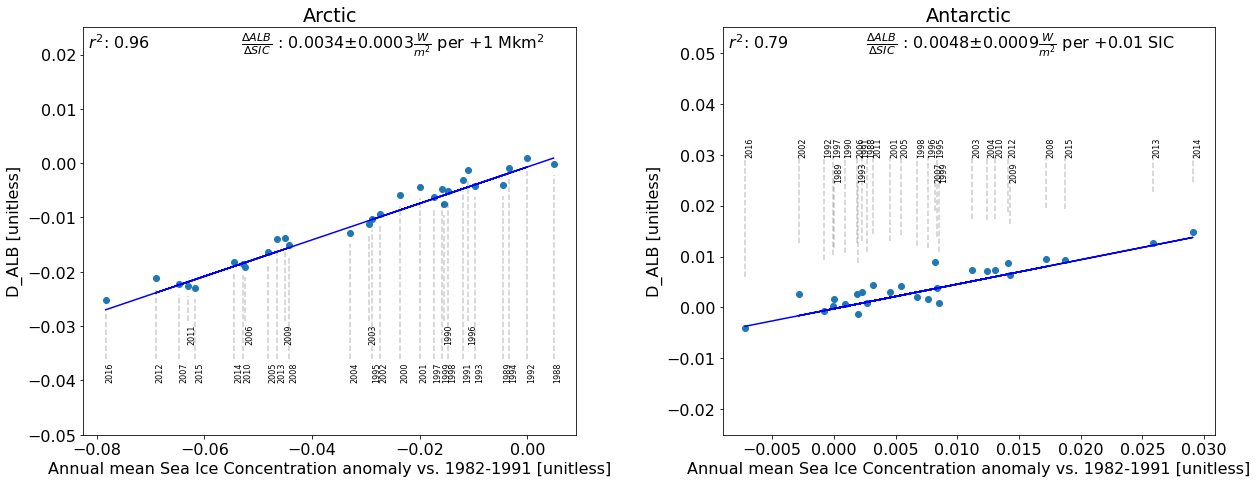

In [673]:
Arctic_SIC_annual_anomaly = xr.concat(meanSI_anoms_NH, dim='time').resample(time='AS').mean().sel(time=slice('1988','2016'))
Antarctic_SIC_annual_anomaly = xr.concat(meanSI_anoms_SH, dim='time').resample(time='AS').mean().sel(time=slice('1988','2016'))

Alb_diff_mean_NH_annual_crop = Alb_diff_mean_NH_annual.sel(time=slice('1988','2016'))
Alb_diff_mean_SH_annual_crop = Alb_diff_mean_SH_annual.sel(time=slice('1988','2016'))


#drop 1984,1994, 2000 from SH because of potentially large missing RF
Antarctic_SIC_annual_anomaly_crop = Antarctic_SIC_annual_anomaly.drop_sel(time=[pd.to_datetime('1994-01-01'), pd.to_datetime('2000-01-01')])


Alb_diff_mean_SH_annual_SIC_crop = Alb_diff_mean_SH_annual_crop.drop_sel(time=[pd.to_datetime('1994-01-01'), pd.to_datetime('2000-01-01')])
Alb_diff_mean_SH_annual_SIC_crop = Alb_diff_mean_SH_annual_crop.drop_sel(time=[pd.to_datetime('1994-01-01'), pd.to_datetime('2000-01-01')])

f=plt.figure(figsize=(18,7))

###SH###
plt.subplot(122)

plt.scatter(Antarctic_SIC_annual_anomaly_crop, Alb_diff_mean_SH_annual_SIC_crop)
downpressed = [1989,1993,2007,1999,2009]
for i, txt in enumerate(Alb_diff_mean_SH_annual_SIC_crop.time):
    if txt.dt.year in downpressed:
        shift = -0.005
    else:
        shift = 0    
    plt.annotate(pd.to_datetime(txt.values).strftime('%Y'), \
                 (Antarctic_SIC_annual_anomaly_crop.values[i], \
                  0.03+shift), fontsize=8, rotation=90)
    plt.vlines(Antarctic_SIC_annual_anomaly_crop.values[i], Alb_diff_mean_SH_annual_SIC_crop[i].values+0.01, 0.03+shift, linestyle='--', alpha=0.2)
    
slope_CC_SH_extent, icpt_CC_SH_extent, lo_slope_CC_SH_extent, hi_slope_CC_SH_extent = theilslopes(Alb_diff_mean_SH_annual_SIC_crop, \
                                                                      Antarctic_SIC_annual_anomaly_crop, alpha=0.95)
slope_CACK_SH_extent, icpt_CACK_SH_extent, lo_slope_CACK_SH_extent, hi_slope_CACK_SH_extent = theilslopes(Alb_diff_mean_SH_annual_SIC_crop, \
                                                                              Antarctic_SIC_annual_anomaly_crop, alpha=0.95)
fitted_CC_SH_extent = Antarctic_SIC_annual_anomaly_crop * slope_CC_SH_extent + icpt_CC_SH_extent
#fitted_CACK_SH_extent = SH_extent_annual * slope_CACK_SH_extent + icpt_CACK_SH_extent

plusminus_CC_SH_extent = slope_CC_SH_extent-lo_slope_CC_SH_extent
#plusminus_CACK_SH_extent = slope_CACK_SH_extent-lo_slope_CACK_SH_extent

plt.text(0.01,  0.95, '$r^2$: ' + str(np.round(r2_score(Alb_diff_mean_SH_annual_SIC_crop, fitted_CC_SH_extent),2)), transform=plt.gca().transAxes)
#plt.text(0.01,  0.88, 'CACK $r^2$: ' + str(np.round(r2_score(Alb_diff_mean_SH_annual_crop, fitted_CACK_SH_extent),2)), transform=plt.gca().transAxes, color='orange')

plt.plot(Antarctic_SIC_annual_anomaly_crop, fitted_CC_SH_extent, linestyle='-', color='blue' )
#plt.plot(SH_extent_annual, fitted_CACK_SH_extent, linestyle='-', color='orange' )

plt.text(0.29,  0.95, r'$ \frac{\Delta ALB}{\Delta SIC}$ : ' + str(np.round(slope_CC_SH_extent/100.,4)) + \
         r'$\pm$' + str(np.round(plusminus_CC_SH_extent/100.,4)) + \
         r'$ \frac{W}{m^2} $' + \
         ' per +0.01 SIC', transform=plt.gca().transAxes)
#plt.text(0.29,  0.88, r'CACK $ \frac{\Delta CrRF}{\Delta SIE}$ : ' + str(np.round(slope_CACK_SH_extent,2)) + \
#         r'$\pm$' + str(np.round(plusminus_CACK_SH_extent,2)) + \
#         r'$ \frac{W}{m^2} $' + \
#         ' per +1 Mkm$^2$', transform=plt.gca().transAxes, color='orange')

plt.xlabel('Annual mean Sea Ice Concentration anomaly vs. 1982-1991 [unitless]')
plt.title('Antarctic')
plt.ylim(-.025, .055)
plt.ylabel('D_ALB [unitless]')


###NH###
plt.subplot(121)

plt.scatter(Arctic_SIC_annual_anomaly, Alb_diff_mean_NH_annual_crop)
uplifted = [2011,2006,2009,2003,1990,1996]
for i, txt in enumerate(Alb_diff_mean_NH_annual_crop.time):
    if (i+1988) in uplifted:
        shift = 0.007
    else:
        shift = 0
    plt.annotate(pd.to_datetime(txt.values).strftime('%Y'), \
                 (Arctic_SIC_annual_anomaly.values[i], \
                  -0.04+shift), fontsize=8, rotation=90)
    plt.vlines(Arctic_SIC_annual_anomaly.values[i], -.036+shift, Alb_diff_mean_NH_annual_crop[i]-0.002, linestyle='--', alpha=0.2)
    
slope_CC_NH_extent, icpt_CC_NH_extent, lo_slope_CC_NH_extent, hi_slope_CC_NH_extent = theilslopes(Alb_diff_mean_NH_annual_crop, \
                                                                      Arctic_SIC_annual_anomaly, alpha=0.95)
slope_CACK_NH_extent, icpt_CACK_NH_extent, lo_slope_CACK_NH_extent, hi_slope_CACK_NH_extent = theilslopes(Alb_diff_mean_NH_annual_crop, \
                                                                              Arctic_SIC_annual_anomaly, alpha=0.95)
fitted_CC_NH_extent = Arctic_SIC_annual_anomaly * slope_CC_NH_extent + icpt_CC_NH_extent
fitted_CACK_NH_extent = Arctic_SIC_annual_anomaly * slope_CACK_NH_extent + icpt_CACK_NH_extent

plusminus_CC_NH_extent = slope_CC_NH_extent-lo_slope_CC_NH_extent
plusminus_CACK_NH_extent = slope_CACK_NH_extent-lo_slope_CACK_NH_extent


plt.text(0.01,  0.95, '$r^2$: ' + str(np.round(r2_score(Alb_diff_mean_NH_annual_crop, fitted_CC_NH_extent),2)), transform=plt.gca().transAxes)
#plt.text(0.01,  0.88, 'CACK $r^2$: ' + str(np.round(r2_score(Alb_diff_mean_NH_annual_crop, fitted_CACK_NH_extent),2)), transform=plt.gca().transAxes, color='orange')

plt.text(0.32,  0.95, r'$ \frac{\Delta ALB}{\Delta SIC}$ : ' + str(np.round(slope_CC_NH_extent/100.,4)) + \
         r'$\pm$' + str(np.round(plusminus_CC_NH_extent/100.,4)) + \
         r'$ \frac{W}{m^2} $' + \
         ' per +1 Mkm$^2$', transform=plt.gca().transAxes)
#plt.text(0.32,  0.88, r'CACK $ \frac{\Delta RF}{\Delta SIE}$ : ' + str(np.round(slope_CACK_NH_extent,2)) + \
#         r'$\pm$' + str(np.round(plusminus_CACK_NH_extent,2)) + \
#         r'$ \frac{W}{m^2} $' + \
#         ' per +1 Mkm$^2$', transform=plt.gca().transAxes, color='orange')


plt.plot(Arctic_SIC_annual_anomaly, fitted_CC_NH_extent, linestyle='-', color='blue' )
#plt.plot(NH_extent_annual, fitted_CACK_NH_extent, linestyle='-', color='orange' )
plt.xlabel('Annual mean Sea Ice Concentration anomaly vs. 1982-1991 [unitless]')
plt.title('Arctic')
plt.ylim(-.05, .025)
plt.ylabel('D_ALB [unitless]')

plt.tight_layout()
plt.savefig(figure_dir + 'Supplementary_Figure_DALB_SIC.png', dpi=300)
plt.savefig(figure_dir + 'Supplementary_Figure_DALB_SIC.pdf', dpi=300)
plt.show()


In [112]:
#Calculate the one-pulse equivalent CO2 emission for the combined RF
#Apply the EESF (Bright & Lund, 2021)
print(CO2_global['mean'].loc['1992':'2018'].mean())
a_co2 = 5.35 * np.log((CO2_global['mean'].loc['1992':'2018'].mean()+1)/CO2_global['mean'].loc['1992':'2018'].mean())
print(a_co2)
kco2 = a_co2 * 28.97 * 1e6 / (44.01*5.12e18)
print(kco2)

EESF = combined_cryo.sel(time=slice('1992','2018')).sum()/(kco2*5.1e14*0.45)
print(EESF)
print((EESF/1000/1e9)*1.194e14)

379.4166666666667
0.014082043664434557
1.8104763342079088e-15
<xarray.DataArray ()>
array(4.9855934)
<xarray.DataArray ()>
array(595.27985198)


In [110]:
(EESF/1000/1e9)*1.194e14/27

<xarray.DataArray ()>
array(22.04740193)

In [111]:
print(combined_cryo.sel(time=slice('1992','2018')).sum())


<xarray.DataArray ()>
array(2.07153559)


In [114]:
(2.07/(5.1e14*kco2*0.45)/1e12)*1.194e14

594.8385825997303

In [116]:
combined_cryo.sel(time=slice('1992','2018')).values

array([-0.10044452,  0.08138423,  0.04135681,  0.07551329, -0.05328778,
        0.1080655 ,  0.09229287,  0.06479546,  0.10504514,  0.05175169,
        0.02814417, -0.01340955, -0.01908002,  0.1240755 ,  0.11314136,
        0.07439552,  0.04837874,  0.02658453,  0.14824586,  0.14174162,
        0.11642516, -0.06499371, -0.00606485,  0.09761229,  0.33647038,
        0.25167804,  0.20171786])